In [1]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
!rm -rf batsman_stats.xlsx bowler_stats.xlsx merged_player_stats.xlsx

In [3]:
# Loading the input files
match_df = pd.read_excel('6671501a18c55_round2_input.xlsx', sheet_name='matchlevel_scorecard')
batsman_df = pd.read_excel('6671501a18c55_round2_input.xlsx', sheet_name='batsman_scorecard')
bowler_df = pd.read_excel('6671501a18c55_round2_input.xlsx', sheet_name='bowler_scorecard')

**BATSMAN STATISTICS**

Creating a new excel sheet with all criteria for batting calculated along with score.


In [4]:
batsman_stats_list = []

# Unique player IDs
unique_batsman_ids = batsman_df['batsman_id'].unique()

In [5]:
# Calculate total points based on the provided rules
def calculate_batsman_points(row):
    points = 0
    
    # Strike Rate points
    if row['batting_strike_rate'] >= 150:
        points += 50
    elif 100 <= row['batting_strike_rate'] < 150:
        points += 40
    elif 80 <= row['batting_strike_rate'] < 100:
        points += 30
    else:
        points += 0
    
    # Batting Average points
    if row['batting_average'] >= 50:
        points += 30
    elif 40 <= row['batting_average'] < 50:
        points += 20
    elif 30 <= row['batting_average'] < 40:
        points += 10
    else:
        points += 5
    
    # 100s points
    if row['100s'] >= 3:
        points += 30
    elif row['100s'] == 2:
        points += 20
    elif row['100s'] == 1:
        points += 10
    
    # 50s points
    if row['50s'] >= 5:
        points += 20
    elif 3 <= row['50s'] < 5:
        points += 10
    elif 1 <= row['50s'] < 3:
        points += 5
    
    return points

In [6]:
# Process each unique batsman - this will find the relevant stats and create a new dataframe
for batsman_id in unique_batsman_ids:
    batsman_data = batsman_df[batsman_df['batsman_id'] == batsman_id]
    
    is_batsman_keeper = 1 if batsman_data['is_batsman_keeper'].any() else 0
    runs = batsman_data['runs'].sum()
    batting_strike_rate = batsman_data['strike_rate'].mean()
    batting_average = batsman_data['runs'].mean()
    
    centuries = (batsman_data['runs'] >= 100).sum()
    fifties = ((batsman_data['runs'] >= 50) & (batsman_data['runs'] < 100)).sum()
    
    batsman_stats_list.append({
        'player_id': batsman_id,
        'runs': runs,
        'batting_strike_rate': batting_strike_rate,
        'batting_average': batting_average,
        '100s': centuries,
        '50s': fifties,
        'is_batsman_keeper': is_batsman_keeper,
    })

batsman_stats = pd.DataFrame(batsman_stats_list)

In [7]:
# Applying the function to calculate total points
batsman_stats['batting_points'] = batsman_stats.apply(calculate_batsman_points, axis=1)

# Sort the dataframe by points, strike rate and batting average in descending order
# batsman_stats = batsman_stats.sort_values(by='batting_points', ascending=False)
batsman_stats = batsman_stats.sort_values(by=['batting_points','batting_strike_rate', 'batting_average'], ascending=[False,False, False])

# Saving to excel file
batsman_stats.to_excel('batsman_stats.xlsx', index=False)

**BOWLER STATISTICS**

Creating a new excel sheet with all criteria for bowling calculated along with score.


In [8]:
bowler_stats_list = []

# Unique player IDs
unique_bowler_ids = bowler_df['bowler_id'].unique()

In [9]:
# Calculate total points based on the provided rules
def calculate_bowler_points(row):
    points = 0
    
    # Strike Rate points
    if row['bowling_strike_rate'] > 24:
        points += 0
    elif 19 < row['bowling_strike_rate'] <= 24:
        points += 10
    elif 15 < row['bowling_strike_rate'] <= 19:
        points += 20
    else:
        points += 30
    
    # Economy
    if row['economy'] >= 7:
        points += 0
    elif 5 < row['economy'] < 7:
        points += 30
    elif 3 < row['economy'] <= 5:
        points += 40
    else:
        points += 50
    
    # Average 
    if row['bowling_average'] > 40:
        points += 0
    elif 30 < row['bowling_average'] <= 40:
        points += 10
    elif 20 < row['bowling_average'] <= 30:
        points += 20
    else:
        points += 30
    
    # 4 wickets per innings
    if row['4w_per_innings'] >= 4:
        points += 30
    elif 2 <= row['4w_per_innings'] <= 3:
        points += 20
    elif row['4w_per_innings'] == 1:
        points += 10
    
    return points

In [10]:
# These 2 functions handle the penalty calculation for strike rate and bowling average - that is when there are 0 wickets, instead of just leaving the value as inf, 
# we try to create a linear growth factor to penalize the player for not taking wickets
# This provides a better estimate which prevents the points from being too high for players who have not taken any wickets

def calculate_penalty_strike_rate(expected, actual, balls_bowled, factor=100):
    if actual > 0:
        return actual
    else:
        # penalty_factor = 1 - math.exp(-balls_bowled / factor)  # Exponential growth factor
        penalty_factor = min(balls_bowled / factor, 1)  # Linear growth factor
        return expected + max(0,(expected - 15)) * penalty_factor

def calculate_penalty_bowling_average(expected, actual, balls_bowled, factor=100):
    if actual > 0:
        return actual
    else:
        # penalty_factor = 1 - math.exp(-balls_bowled / factor)  # Exponential growth factor
        penalty_factor = min(balls_bowled / factor, 1)  # Linear growth factor
        return expected + max(0,(expected - 20)) * penalty_factor

# median balls bowled is preferred over mean to avoid bias due to outliers
median_balls_bowled = bowler_df['balls_bowled'].median()

# Process each unique bowler
for bowler_id in unique_bowler_ids:
    bowler_data = bowler_df[bowler_df['bowler_id'] == bowler_id]

    is_bowler_keeper = 1 if bowler_data['is_bowler_keeper'].any() else 0

    # Calculate the average strike rate and bowling average for cases where wicket_count > 0
    valid_strike_rates = bowler_data[bowler_data['wicket_count'] > 0]['balls_bowled'] / bowler_data[bowler_data['wicket_count'] > 0]['wicket_count']
    valid_averages = bowler_data[bowler_data['wicket_count'] > 0]['runs'] / bowler_data[bowler_data['wicket_count'] > 0]['wicket_count']
    
    # using median instead of mean to avoid bias due to outliers
    average_strike_rate = valid_strike_rates.median() if not valid_strike_rates.empty else float('inf')
    # average_strike_rate = valid_strike_rates.mean() if not valid_strike_rates.empty else float('inf')
    average_bowling_average = valid_averages.median() if not valid_averages.empty else float('inf')
    # average_bowling_average = valid_averages.mean() if not valid_averages.empty else float('inf')
    
    balls_bowled = bowler_data['balls_bowled'].sum()
    wickets = bowler_data['wicket_count'].sum()
    economy = bowler_data['economy'].mean()
    four_w_per_innings = (bowler_data['wicket_count'] >= 4).sum()

    strike_rates = []
    averages = []

    # making use of the penalty functions to calculate the strike rate and bowling average
    for _, row in bowler_data.iterrows():
        if row['balls_bowled'] > 0:
            # expected_wickets = row['balls_bowled'] / average_strike_rate
            # expected_wickets = row['balls_bowled'] / average_strike_rate if average_strike_rate != float('inf') else 0
            actual_wickets = row['wicket_count']
            
            strike_rate = calculate_penalty_strike_rate(
                expected = average_strike_rate,
                actual = row['balls_bowled'] / actual_wickets if actual_wickets > 0 else 0,
                balls_bowled=row['balls_bowled'],
                factor=median_balls_bowled
            )
            
            bowling_average = calculate_penalty_bowling_average(
                expected = average_bowling_average,
                actual=row['runs'] / actual_wickets if actual_wickets > 0 else 0,
                balls_bowled=row['balls_bowled'],
                factor=median_balls_bowled
            )
            
            strike_rates.append(strike_rate)
            averages.append(bowling_average)
    
    if strike_rates:
        bowling_strike_rate = sum(strike_rates) / len(strike_rates)
    else:
        bowling_strike_rate = None
    
    if averages:
        bowling_average = sum(averages) / len(averages)
    else:
        bowling_average = None   
    
    bowler_stats_list.append({
        'player_id': bowler_id,
        'wickets': wickets,
        'bowling_strike_rate': bowling_strike_rate,
        'economy': economy,
        'bowling_average': bowling_average,
        '4w_per_innings': four_w_per_innings,
        'is_bowler_keeper': is_bowler_keeper,
        'balls_bowled': balls_bowled,
    })

# Creating the DataFrame from the list
bowler_stats = pd.DataFrame(bowler_stats_list)


In [11]:
# Applying the function to calculate total points
bowler_stats['bowling_points'] = bowler_stats.apply(calculate_bowler_points, axis=1)

# Sort the dataframe by total_points, balls_bowled in descending order and economy in ascending order
bowler_stats = bowler_stats.sort_values(by=['bowling_points', 'balls_bowled', 'economy'], ascending=[False, False, True])

# Save the dataframe to an Excel file
bowler_stats.to_excel('bowler_stats.xlsx', index=False)

**OVERALL STATS**

We combine the bowling and batting stats based on matching IDs to obtain a single list of all players.

In [12]:
# Load the data from the two Excel sheets
batsman_stats = pd.read_excel('batsman_stats.xlsx')
bowler_stats = pd.read_excel('bowler_stats.xlsx')

# Merge the dataframes on 'player_id', using outer join to include all entries
merged_stats = pd.merge(batsman_stats, bowler_stats, on='player_id', how='outer')

# Calculate total_points
merged_stats['total_points'] = merged_stats['batting_points'].fillna(0) + merged_stats['bowling_points'].fillna(0)

# Sort the dataframe by total_points in descending order
merged_stats = merged_stats.sort_values(by='total_points', ascending=False)

# Save the final dataframe to an Excel sheet
merged_stats.to_excel('merged_player_stats.xlsx', index=False)

Obtaining the scores and statistics of the near best 11 players given in the csv file.

In [13]:
# Load the CSV file containing player IDs
playing11_df = pd.read_csv('6671502b6a89e_nearbest_playing11.csv')
merged_stats = pd.read_excel('merged_player_stats.xlsx')

total_score = 0

# Iterate through each player ID in the playing 11 list
for player_id in playing11_df['Player_id']:
    print(f"Stats for Player ID: {player_id}")
    
    # Find the player in the batsman stats
    batsman_entry = batsman_stats[batsman_stats['player_id'] == player_id]
    if not batsman_entry.empty:
        print("Batsman Stats:")
        print(tabulate(batsman_entry, headers='keys', tablefmt='pretty'))
    else:
        print("Not found in Batsman Stats")
    
    # Find the player in the bowler stats
    bowler_entry = bowler_stats[bowler_stats['player_id'] == player_id]
    if not bowler_entry.empty:
        print("Bowler Stats:")
        print(tabulate(bowler_entry, headers='keys', tablefmt='pretty'))
    else:
        print("Not found in Bowler Stats")
    
    # Find the player in the merged player stats
    merged_entry = merged_stats[merged_stats['player_id'] == player_id]
    if not merged_entry.empty:
        print("Merged Player Stats:")
        print(tabulate(merged_entry, headers='keys', tablefmt='pretty'))
        if 'total_points' in merged_entry.columns:
            total_score += merged_entry['total_points'].values[0]
    else:
        print("Not found in Merged Player Stats")
    
    print("\n" + "-"*50 + "\n")

print("\n\nThe total score of the near best 11 players is : ", total_score)

Stats for Player ID: 325814
Batsman Stats:
+----+-----------+-------+---------------------+-------------------+------+-----+-------------------+----------------+
|    | player_id | runs  | batting_strike_rate |  batting_average  | 100s | 50s | is_batsman_keeper | batting_points |
+----+-----------+-------+---------------------+-------------------+------+-----+-------------------+----------------+
| 26 | 325814.0  | 822.0 |  134.6659259259259  | 30.44444444444444 | 1.0  | 7.0 |        0.0        |      80.0      |
+----+-----------+-------+---------------------+-------------------+------+-----+-------------------+----------------+
Bowler Stats:
+-----+-----------+---------+---------------------+---------+-----------------+----------------+------------------+--------------+----------------+
|     | player_id | wickets | bowling_strike_rate | economy | bowling_average | 4w_per_innings | is_bowler_keeper | balls_bowled | bowling_points |
+-----+-----------+---------+---------------------+-

In [14]:
# This code block is for the helper function to plot the performance of a player over time
# We will draw 2 graphs for each player
# 1. Total points vs Match Date - such that we consider points scored uptill that match
# 2. Rolling average of total points vs Match Date - such that we consider the average of points scored in the last 10 matches

# Calculate batting points
def batsman_points(row):
    points = 0
    
    # Strike Rate points
    if row['strike_rate'] >= 150:
        points += 50
    elif 100 <= row['strike_rate'] < 150:
        points += 40
    elif 80 <= row['strike_rate'] < 100:
        points += 30
    
    # Batting Average points
    if row['batting_average'] >= 50:
        points += 30
    elif 40 <= row['batting_average'] < 50:
        points += 20
    elif 30 <= row['batting_average'] < 40:
        points += 10
    else:
        points += 5
    
    # 100s points
    if row['hundreds'] >= 3:
        points += 30
    elif row['hundreds'] == 2:
        points += 20
    elif row['hundreds'] == 1:
        points += 10
    
    # 50s points
    if row['fifties'] >= 5:
        points += 20
    elif 3 <= row['fifties'] < 5:
        points += 10
    elif 1 <= row['fifties'] < 3:
        points += 5
    
    return points

# Calculate bowling points
def bowler_points(row):
    points = 0
    
    # Strike Rate points
    if row['bowling_strike_rate'] <= 15:
        points += 30
    elif 15 < row['bowling_strike_rate'] <= 19:
        points += 20
    elif 19 < row['bowling_strike_rate'] <= 24:
        points += 10
    
    # Economy points
    if row['economy'] <= 3:
        points += 50
    elif 3 < row['economy'] <= 5:
        points += 40
    elif 5 < row['economy'] < 7:
        points += 30
    
    # Average points
    if row['bowling_average'] <= 20:
        points += 30
    elif 20 < row['bowling_average'] <= 30:
        points += 20
    elif 30 < row['bowling_average'] <= 40:
        points += 10
    
    # 4 wickets per innings points
    if row['four_wicket_hauls'] >= 4:
        points += 30
    elif 2 <= row['four_wicket_hauls'] <= 3:
        points += 20
    elif row['four_wicket_hauls'] == 1:
        points += 10
    
    return points

def helper(player_id, batsman_df, bowler_df):
    # Filter dataframes for the specific player
    batsman_data = batsman_df[batsman_df['batsman_id'] == player_id].sort_values('match_dt')
    bowler_data = bowler_df[bowler_df['bowler_id'] == player_id].sort_values('match_dt')

    def calc_batsman_stats(data):
        cumulative_stats = data.sort_values('match_dt').copy()
        cumulative_stats['runs'] = cumulative_stats['runs'].cumsum()
        cumulative_stats['balls_faced'] = cumulative_stats['balls_faced'].cumsum()
        cumulative_stats['innings'] = range(1, len(cumulative_stats) + 1)
        cumulative_stats['hundreds'] = (cumulative_stats['runs'] >= 100).cumsum()
        cumulative_stats['fifties'] = ((cumulative_stats['runs'] >= 50) & (cumulative_stats['runs'] < 100)).cumsum()
        
        # Calculate match-wise strike rate
        cumulative_stats['match_strike_rate'] = (data['runs'] / data['balls_faced'] * 100).fillna(0)
        
        # Calculate moving average of strike rate
        cumulative_stats['strike_rate'] = cumulative_stats['match_strike_rate'].expanding().mean()
        
        # Calculate moving batting average
        cumulative_stats['batting_average'] = cumulative_stats['runs'] / cumulative_stats['innings']
        
        cumulative_stats['batting_points'] = cumulative_stats.apply(batsman_points, axis=1)
        return cumulative_stats

    def calc_bowler_stats(data):
        cumulative_stats = data.sort_values('match_dt').copy()
        cumulative_stats['wickets'] = cumulative_stats['wicket_count'].cumsum()
        cumulative_stats['runs_conceded'] = cumulative_stats['runs'].cumsum()
        cumulative_stats['balls_bowled'] = cumulative_stats['balls_bowled'].cumsum()
        cumulative_stats['innings'] = range(1, len(cumulative_stats) + 1)
        cumulative_stats['four_wicket_hauls'] = (cumulative_stats['wicket_count'] >= 4).cumsum()
        
        # Calculate match-wise bowling strike rate
        cumulative_stats['match_bowling_strike_rate'] = data['balls_bowled'] / data['wicket_count'].replace(0, 1)
        
        # Calculate moving average of bowling strike rate
        cumulative_stats['bowling_strike_rate'] = cumulative_stats['match_bowling_strike_rate'].expanding().mean()
        
        # Calculate match-wise bowling average
        cumulative_stats['match_bowling_average'] = data['runs'] / data['wicket_count'].replace(0, 1)
        
        # Calculate moving average of bowling average
        cumulative_stats['bowling_average'] = cumulative_stats['match_bowling_average'].expanding().mean()
        
        # Calculate match-wise economy rate
        cumulative_stats['match_economy'] = (data['runs'] / (data['balls_bowled'] / 6)).fillna(0)
        
        # Calculate moving average of economy rate
        cumulative_stats['economy'] = cumulative_stats['match_economy'].expanding().mean()
        
        cumulative_stats['bowling_points'] = cumulative_stats.apply(bowler_points, axis=1)
        return cumulative_stats
    # Calculate cumulative stats
    batsman_stats = calc_batsman_stats(batsman_data)
    bowler_stats = calc_bowler_stats(bowler_data)

    # Calculate points
    batsman_stats['batting_points'] = batsman_stats.apply(batsman_points, axis=1)
    bowler_stats['bowling_points'] = bowler_stats.apply(bowler_points, axis=1)

    # Merge batting and bowling stats
    all_stats = pd.merge(batsman_stats, bowler_stats, on='match_dt', how='outer', suffixes=('_bat', '_bowl'))
    all_stats = all_stats.sort_values('match_dt')

    # Fill NaN values with 0 for points columns
    all_stats['batting_points'] = all_stats['batting_points'].fillna(0)
    all_stats['bowling_points'] = all_stats['bowling_points'].fillna(0)

    # Calculate total points
    all_stats['total_points'] = all_stats['batting_points'] + all_stats['bowling_points']

    # Calculate rolling average
    window_size = 10  # You can adjust this value
    all_stats['rolling_avg'] = all_stats['total_points'].rolling(window=window_size, min_periods=1).mean()

    # Convert Match_Dt to datetime
    all_stats['match_dt'] = pd.to_datetime(all_stats['match_dt'])

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.plot(all_stats['match_dt'], all_stats['total_points'], label='Total Points', alpha=0.5, marker='^')
    plt.plot(all_stats['match_dt'], all_stats['rolling_avg'], label=f'{window_size}-Match Rolling Average', linewidth=2)

    plt.xlabel('Match Date')
    plt.ylabel('Points')
    plt.title(f'Player Performance Over Time (Player ID: {player_id})')
    plt.legend()
    plt.grid(True)

    # Format x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

    plt.tight_layout()
    plt.show()

In [15]:
def player_perfomance(player_id, merged_stats = merged_stats, batsman_stats = batsman_stats, bowler_stats = bowler_stats, match_df = match_df, batsman_df = batsman_df, bowler_df = bowler_df):
    
    """
        Function to calculate the performance of a player based on the player_id and visualise the same using plots
        Args: 
            player_id: int - The unique player ID
            merged_stats: DataFrame - The merged stats of the players
            batsman_stats: DataFrame - The batsman stats of the players
            bowler_stats: DataFrame - The bowler stats of the players
            match_df: DataFrame - The match level scorecard
            batsman_df: DataFrame - The batsman level score 
            bowler_df: DataFrame - The bowler level score
        Returns:
            None

        Prints relevant statistics and plots the performance of the player
        Plots made:
        1. Runs and Balls Faced vs Match Date
        2. Strike Rate vs Match Date
        3. Fours and Sixes vs Match Date
        4. Wicket Count, Runs Conceded, and Balls Bowled vs Match Date
        5. Economy vs Match Date
        6. Perfomance vs Match Date (Total Points and Rolling Average of Total Points) - done with the helper function
    """
    # Filter data for the specified player_id
    player_batsman_df = batsman_df[batsman_df['batsman_id'] == player_id]
    player_bowler_df = bowler_df[bowler_df['bowler_id'] == player_id]

    # sorting matches in chronological order for plotting
    player_batsman_df.sort_values('match_dt', ascending = True)
    player_bowler_df.sort_values('match_dt', ascending = True)

    # Plot runs and balls faced vs match_dt
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 5, 1)
    plt.plot(player_batsman_df['match_dt'], player_batsman_df['runs'], label='Runs')
    plt.plot(player_batsman_df['match_dt'], player_batsman_df['balls_faced'], label='Balls Faced')
    plt.xlabel('Matches')
    plt.ylabel('Count')
    plt.title('Runs and Balls Faced vs Match Date')
    plt.legend()

    # Plot strike rate vs match_dt
    plt.subplot(1, 5, 2)
    plt.plot(player_batsman_df['match_dt'], player_batsman_df['strike_rate'])
    plt.xlabel('Matches')
    plt.ylabel('Strike Rate')
    plt.title('Strike Rate vs Match Date')
    # plt.tight_layout()

    # Plot fours and sixes vs match_dt
    plt.subplot(1, 5, 3)
    plt.plot(player_batsman_df['match_dt'], player_batsman_df['Fours'], label='Fours')
    plt.plot(player_batsman_df['match_dt'], player_batsman_df['Sixes'], label='Sixes')
    plt.xlabel('Matches')
    plt.ylabel('Count')
    plt.title('Fours and Sixes vs Match Date')
    plt.legend()

    # Plot wicket_count, runs conceded, and balls_bowled vs match_dt
    plt.subplot(1, 5, 4)
    plt.plot(player_bowler_df['match_dt'], player_bowler_df['wicket_count'], label='Wicket Count')
    plt.plot(player_bowler_df['match_dt'], player_bowler_df['runs'], label='Runs Conceded')
    plt.plot(player_bowler_df['match_dt'], player_bowler_df['balls_bowled'], label='Balls Bowled')
    plt.xlabel('Matches')
    plt.ylabel('Count')
    plt.title('Wicket Count, Runs Conceded, and Balls Bowled vs Match Date')
    plt.legend()
    # plt.tight_layout()

    # Plot economy vs match_dt
    plt.subplot(1, 5, 5)
    plt.plot(player_bowler_df['match_dt'], player_bowler_df['economy'])
    plt.xlabel('Matches')
    plt.ylabel('Economy')
    plt.title('Economy vs Match Date')

     # Format x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

    plt.tight_layout()
    plt.show()
    
    # Print relevant statistics
    print(f"Player ID: {player_id}")
    if not player_batsman_df.empty:
        print("Batting Performance:")
        # print(player_batsman_df.describe())
        print(tabulate(player_batsman_df.describe(), headers='keys', tablefmt='pretty'))
    if not player_bowler_df.empty:
        print("Bowling Performance:")
        # print(player_bowler_df.describe())
        print(tabulate(player_bowler_df.describe(), headers='keys', tablefmt='pretty'))

    # Find the player in the batsman stats
    batsman_entry = batsman_stats[batsman_stats['player_id'] == player_id]
    if not batsman_entry.empty:
        print("Batsman Stats:")
        print(tabulate(batsman_entry, headers='keys', tablefmt='pretty'))
    else:
        print("Not found in Batsman Stats")
    
    # Find the player in the bowler stats
    bowler_entry = bowler_stats[bowler_stats['player_id'] == player_id]
    if not bowler_entry.empty:
        print("Bowler Stats:")
        print(tabulate(bowler_entry, headers='keys', tablefmt='pretty'))
    else:
        print("Not found in Bowler Stats")
    
    # Find the player in the merged player stats
    merged_entry = merged_stats[merged_stats['player_id'] == player_id]
    if not merged_entry.empty:
        print("Merged Player Stats:")
        print(tabulate(merged_entry, headers='keys', tablefmt='pretty'))
    else:
        print("Not found in Merged Player Stats")
    
    print("\n" + "-"*50 + "\n")
    
    print("\n\nMatch wise performance based on batting, bowling and total points\n\n")
    helper(player_id, batsman_df, bowler_df)

**CHOOSING WICKETKEEPERS**

We choose the top wicket keepers from our merged_player_stats.xlxs sheet and do comparisons among them.
* Clearly, player with ID 2331475 emerges as the selection based on number of points. We also compare the next 3 players in order by calling the player_perfomance function to see who will qualify if we need one more wicketkeeper. 
* From the perfomance vs time graph (last graph) and the other batting and bowling plots obtained for each player, we can clearly see despite having the same points player 1742453 lags behind as he on an average his points lie between 40 and 60 while for the other 2 it lies between 80 and 100. 
* Furthermore, the player 2319638 can be chosen as he has played more matches and he has been at par or better than player 4888218 in his latest few matches.

Thus, final choice :
1. 4888218 - 140 points
2. 2319638 - 140 points

In [16]:
wicket_keeper_df = merged_stats[(merged_stats['is_batsman_keeper'] == 1) | (merged_stats['is_bowler_keeper'] == 1)]
wicket_keeper_df = wicket_keeper_df[:5]
wicket_keeper_df

player_id    runs  batting_strike_rate  batting_average  100s   50s  \
33    2331475  1287.0           122.147442        29.930233   2.0   5.0   
47    4888218   484.0           140.603636        22.000000   0.0   1.0   
48    1742453   231.0            85.384444        12.833333   0.0   1.0   
49    2319638   526.0           103.500938        16.437500   0.0   2.0   
80    5764576  2573.0           124.955686        25.225490   1.0  17.0   

    is_batsman_keeper  batting_points  wickets  bowling_strike_rate  \
33                1.0            85.0      1.0             6.000000   
47                1.0            50.0      3.0            12.857143   
48                1.0            40.0      2.0             3.000000   
49                1.0            50.0      2.0            12.000000   
80                1.0            75.0      9.0             6.777778   

      economy  bowling_average  4w_per_innings  is_bowler_keeper  \
33  12.000000         12.00000             0.0               0.0   
47   6.500000          8.00000             0.0               0.0   
48   4.000000          2.00000             0.0               0.0   
49   6.945000         12.00000             0.0               0.0   
80   8.604444         10.12963             0.0               0.0   

    balls_bowled  bowling_points  total_points  
33           6.0            60.0           145  
47          78.0            90.0           140  
48           6.0           100.0           140  
49          66.0            90.0           140  
80         251.0            60.0           135

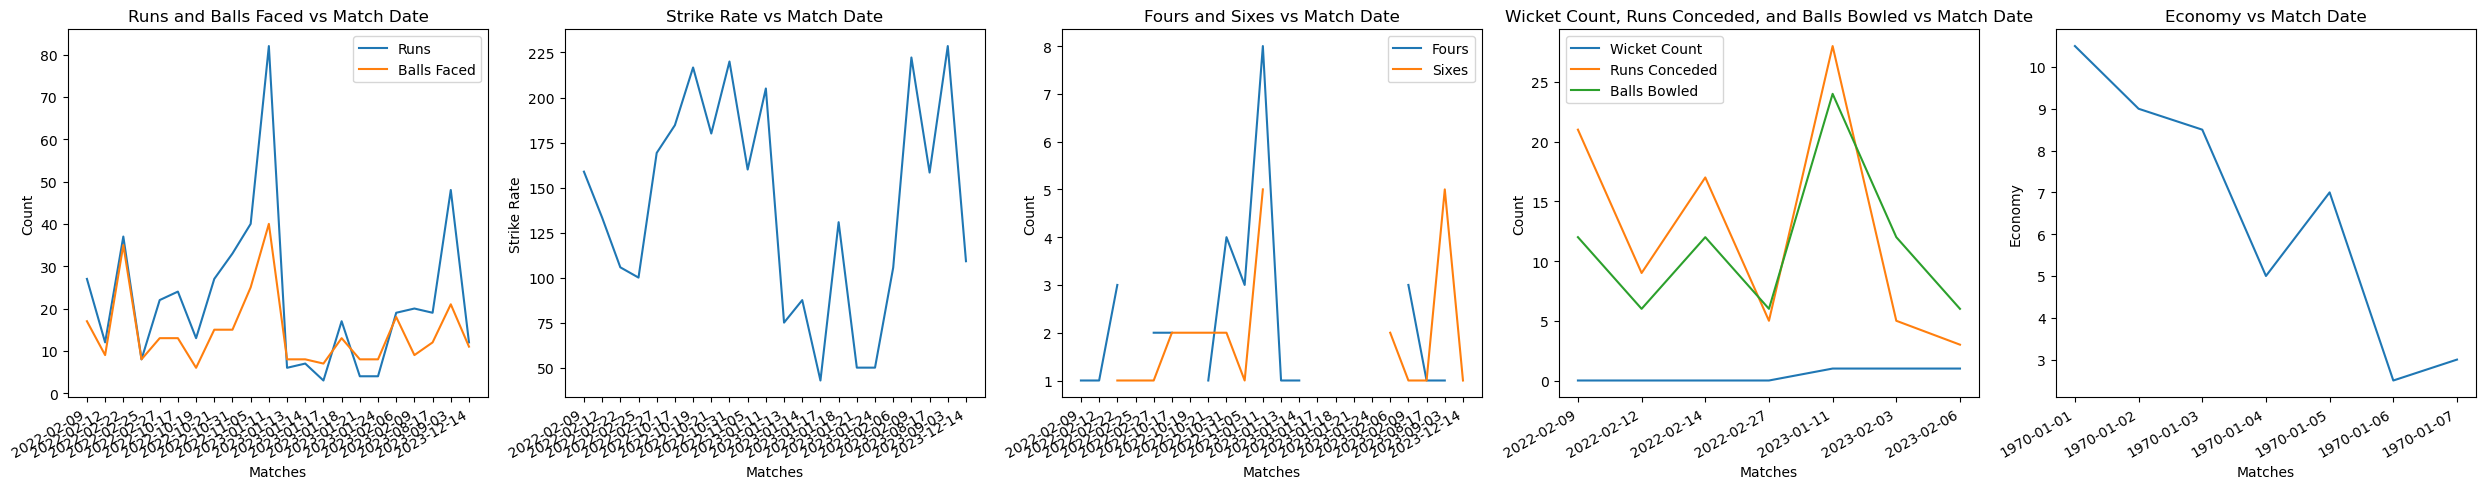

Player ID: 4888218
Batting Performance:
+-------+-------------------+------------+--------------------+---------------------+---------------------+--------------------+-------------------+--------------------+--------------------+------------------+---------------------+--------------------+-------------------+--------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain |  is_batsman_keeper  |       inning        |        runs        |    balls_faced    |  over_faced_first  |     bowler_id      | is_bowler_keeper |  is_bowler_captain  |    strike_rate     |       Fours       |       Sixes        |      ingestion_timestamp      |
+-------+-------------------+------------+--------------------+---------------------+---------------------+--------------------+-------------------+--------------------+--------------------+------------------+---------------------+--------------------+-------------------+--------------------+---------------

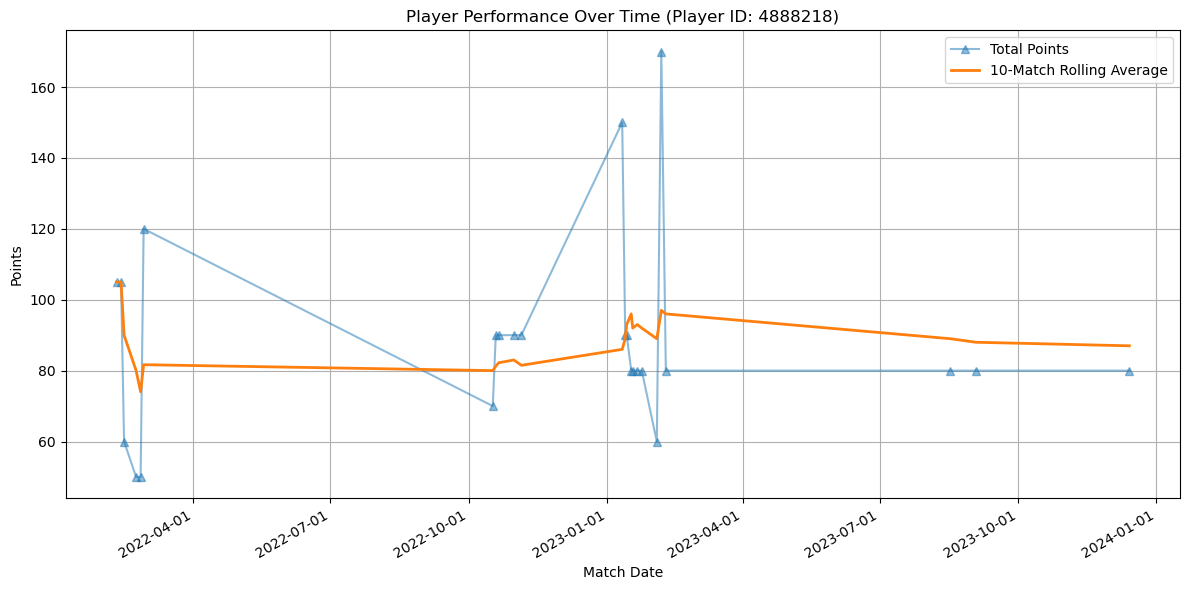

In [17]:
player_perfomance(4888218)

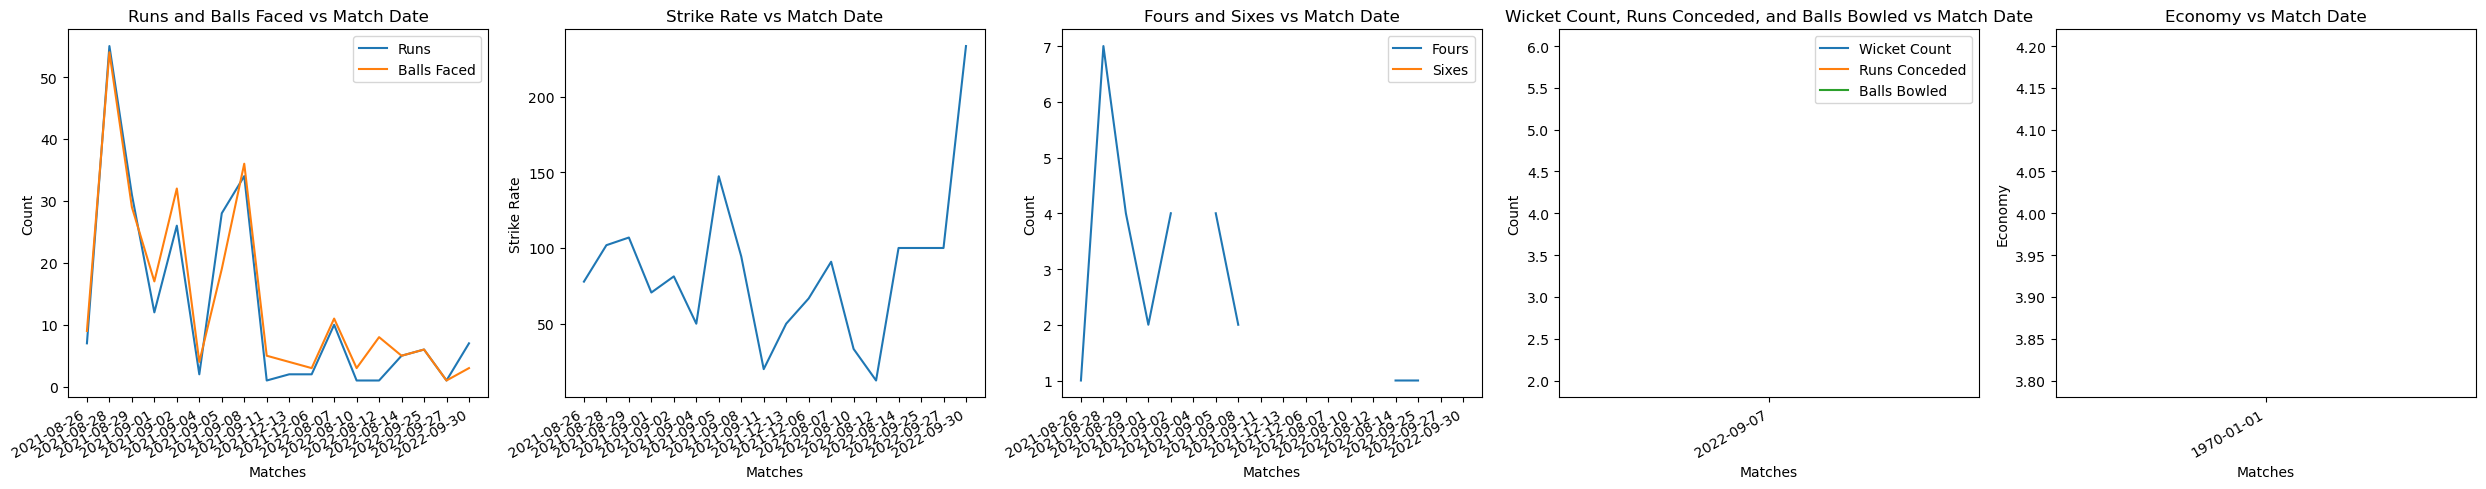

Player ID: 1742453
Batting Performance:
+-------+-------------------+------------+--------------------+---------------------+---------------------+--------------------+--------------------+-------------------+--------------------+------------------+---------------------+--------------------+--------------------+-------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain |  is_batsman_keeper  |       inning        |        runs        |    balls_faced     | over_faced_first  |     bowler_id      | is_bowler_keeper |  is_bowler_captain  |    strike_rate     |       Fours        | Sixes |      ingestion_timestamp      |
+-------+-------------------+------------+--------------------+---------------------+---------------------+--------------------+--------------------+-------------------+--------------------+------------------+---------------------+--------------------+--------------------+-------+-------------------------------+
| count |       18

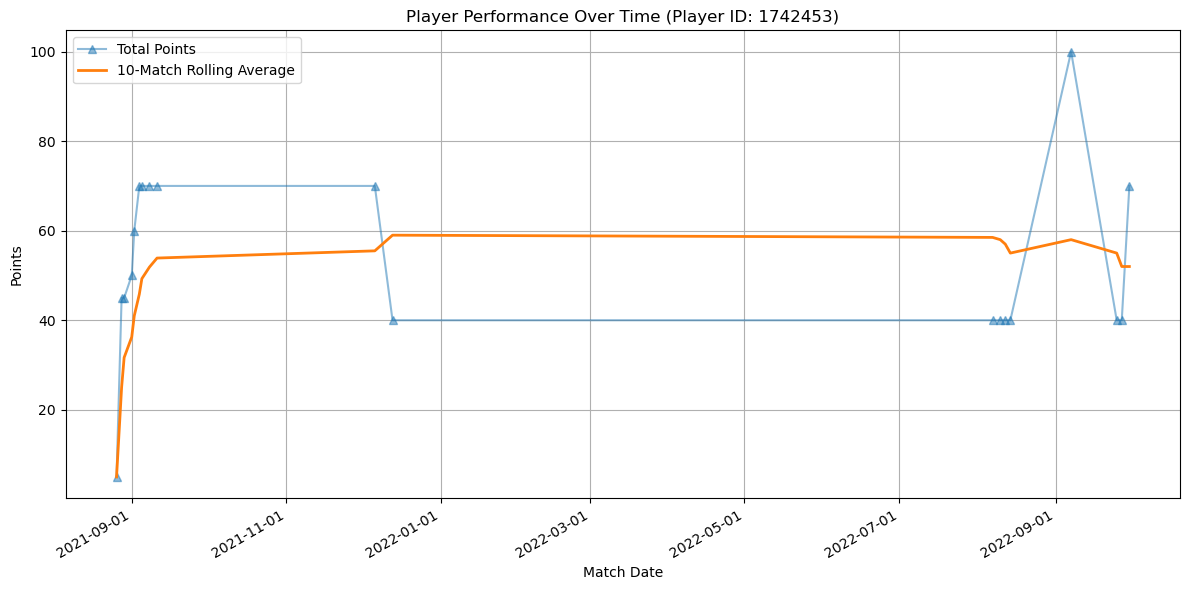

In [18]:
player_perfomance(1742453)

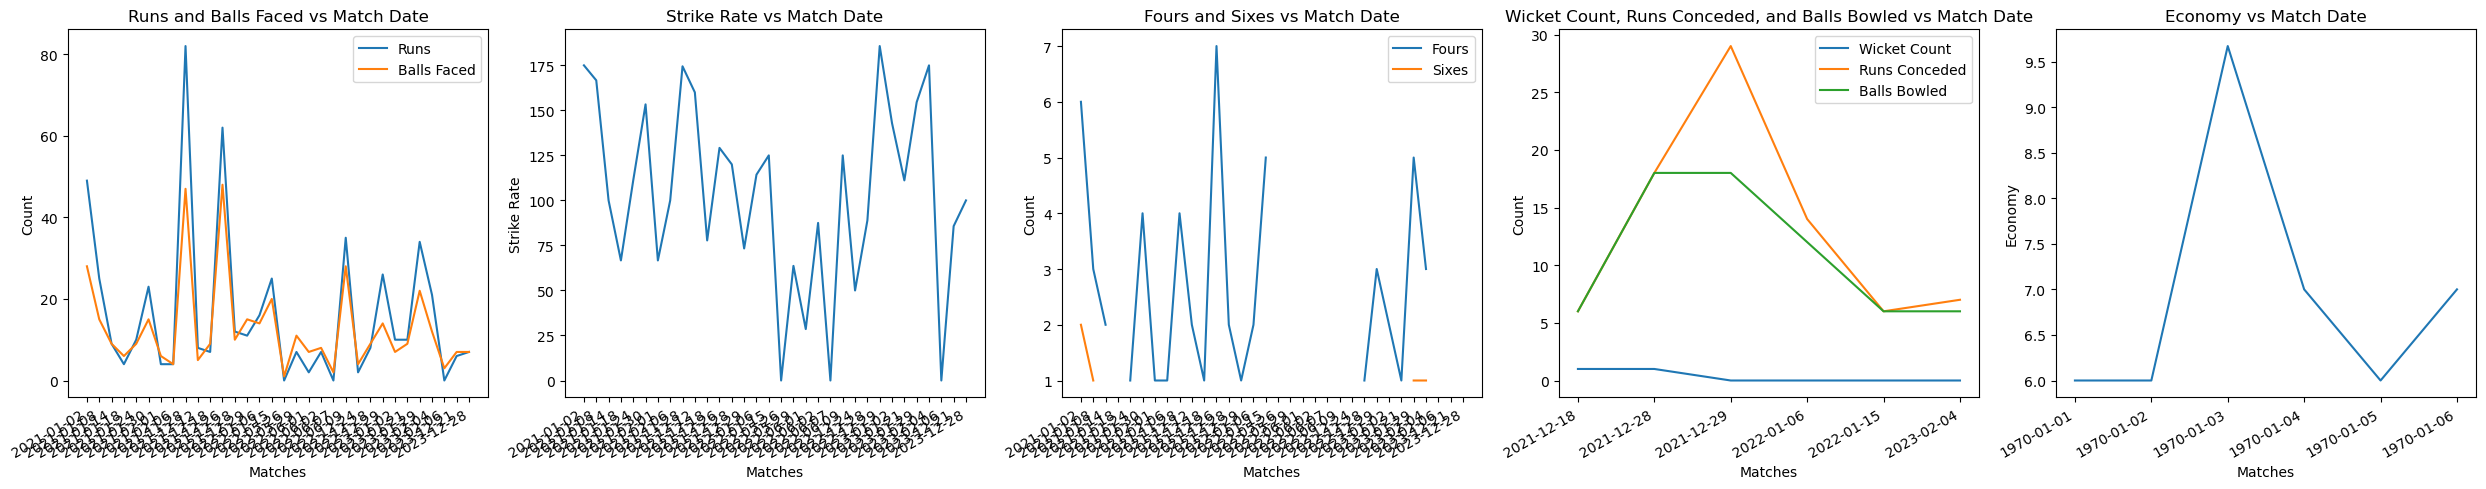

Player ID: 2319638
Batting Performance:
+-------+-------------------+------------+--------------------+--------------------+---------------------+------------------+--------------------+-----------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain | is_batsman_keeper  |       inning        |       runs       |    balls_faced     |   over_faced_first    |     bowler_id      | is_bowler_keeper | is_bowler_captain |    strike_rate     |       Fours       |       Sixes        |      ingestion_timestamp      |
+-------+-------------------+------------+--------------------+--------------------+---------------------+------------------+--------------------+-----------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+------------------

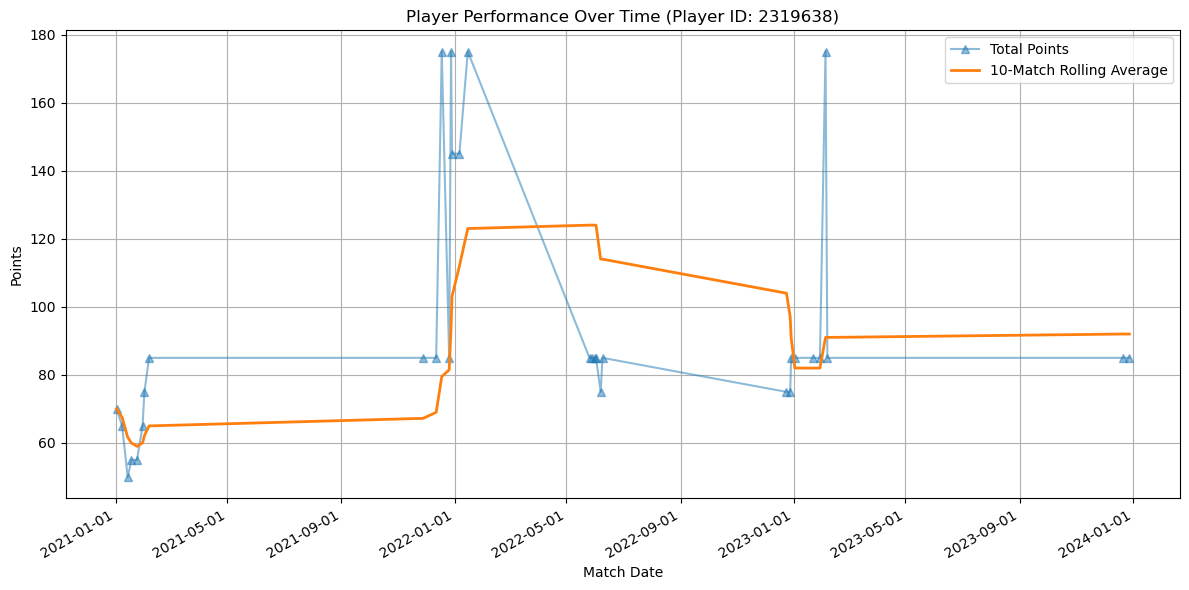

In [19]:
player_perfomance(2319638)

**BATSMAN SELECTION**

Selecting the highest ranking batsman from the batsman_stats.xlsx - note that we *ONLY* use batting scores.
* We list out the 10 highest players first. As the first 5 players, all have the same batting score, we identify a preference order based on their recent perfomances. We print the player_perfomance for each of them.
* We first check the "Player Perfomance over Time" graph for them to get an idea about how they have been performing - both overall and on an average basis of the last 10 matches.
* Player 2263736 is chosen first and 313809 second. While we observe a sharp decline in his performance from 100 to 90 points in the moving average curve, we note that he consistently maintains his value of 90 points. The only other batsman to maintain a near 90 score is 313809. A further analysis of other statistics and graphs such as strike rate and batting average makes 2263736 the first player and 313809 the second.
* The next selection is 7491224. Again, we check the perfomance vs tiem graph and note that he improves/ stays consistent between 80 to 90 in his recent matches.
* The next selection is 3125562 as he has perfomed better in the recent matches as compared to 2162782.

Final order of selection of batsmen:

1. 2263736 - 100 points
2. 313809 - 100 points
3. 7491224 - 100 points
4. 3125562 - 100 points
5. 2162782 - 100 points

In [20]:
batsman_stats[:10]

player_id  runs  batting_strike_rate  batting_average  100s  50s  \
0    3125562  2551           136.978500        31.887500     4   19   
1    7491224  1983           123.351250        35.410714     4    9   
2    2162782  3498           123.307835        36.061856     6   26   
3    2263736  4031           115.673261        43.815217     2   38   
4     313809  2798           114.388095        33.309524     3   20   
5    2789646   283           166.772000        56.600000     1    1   
6    2231928  1888           132.507568        25.513514     3   11   
7    1749075  3203           130.018214        28.598214     3   20   
8    2275195  2480           126.458211        26.105263     3   14   
9    4635658  1796           124.756984        28.507937     3   10   

   is_batsman_keeper  batting_points  
0                  0             100  
1                  0             100  
2                  1             100  
3                  1             100  
4                  0             100  
5                  1              95  
6                  0              95  
7                  0              95  
8                  0              95  
9                  1              95

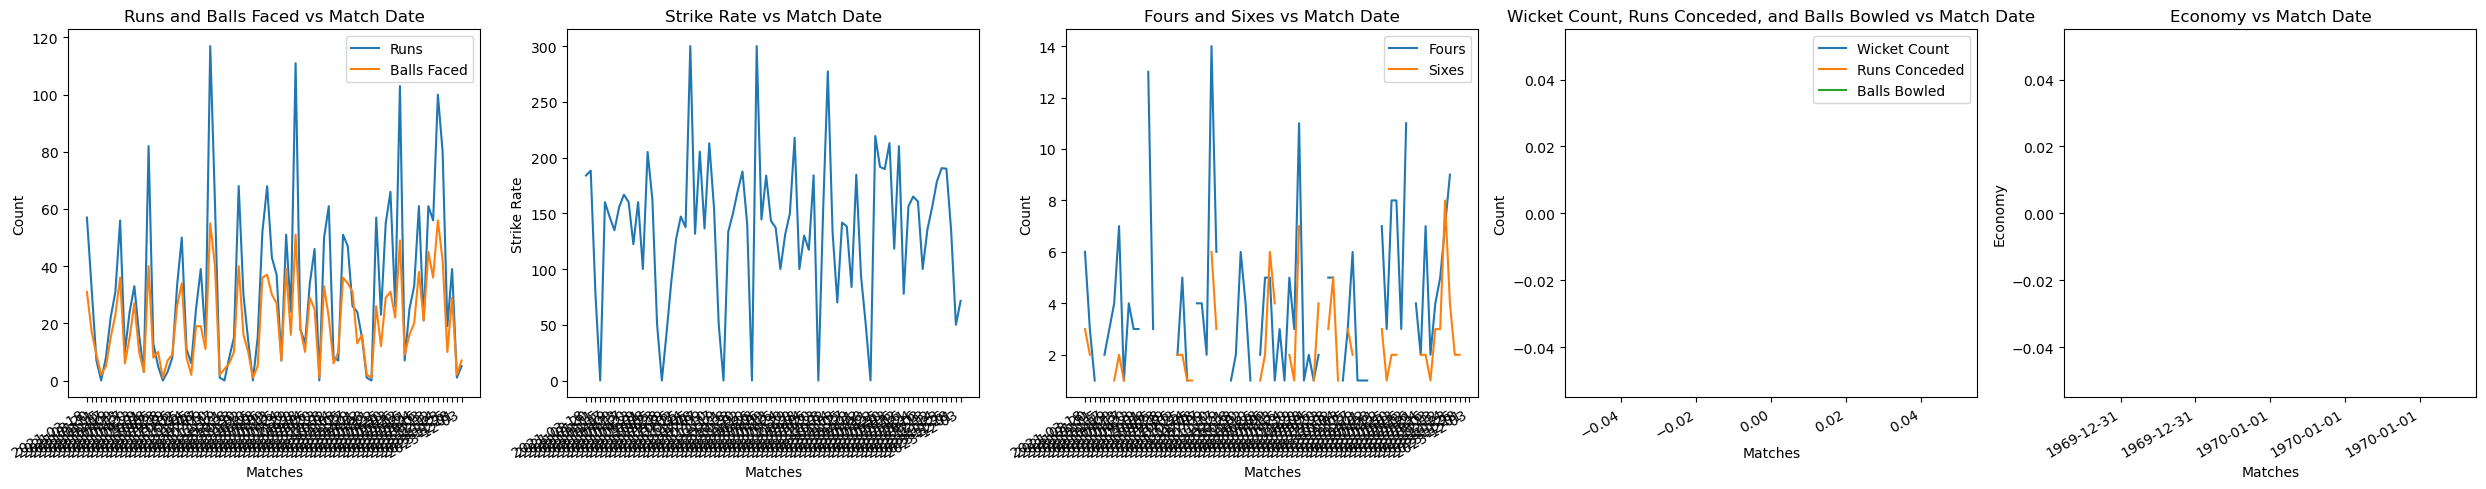

Player ID: 3125562
Batting Performance:
+-------+-------------------+------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------------+-------------------+--------------------+--------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain | is_batsman_keeper |      inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id      | is_bowler_keeper |  is_bowler_captain  |    strike_rate    |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+-------------------+------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------------+-------------------+--------------------+--------------------+------------------------

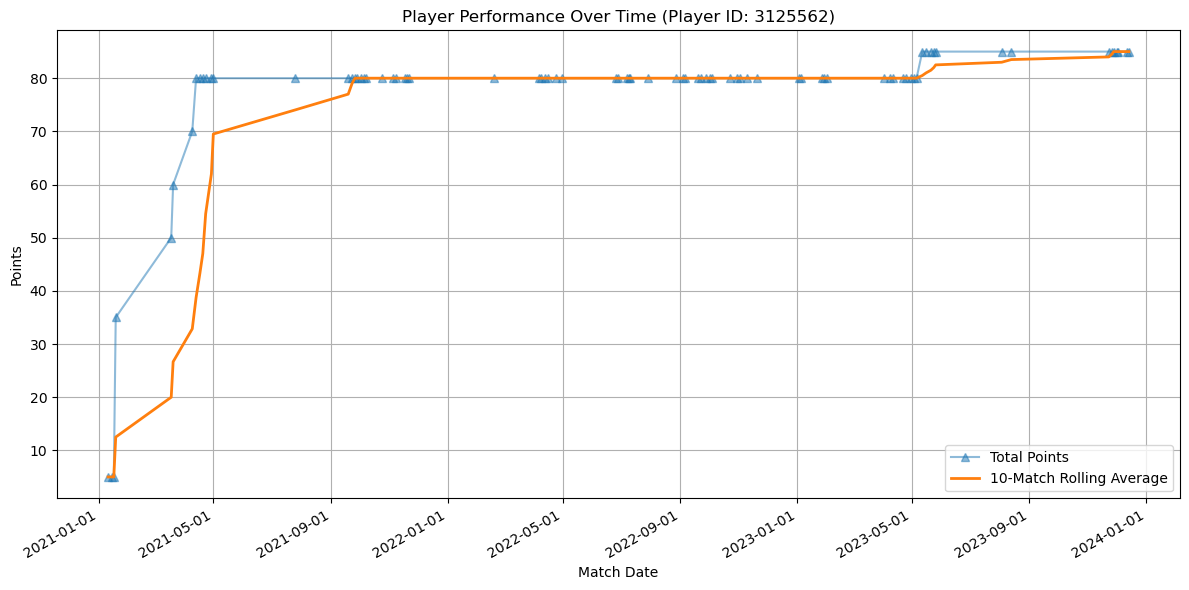

In [21]:
player_perfomance(3125562)

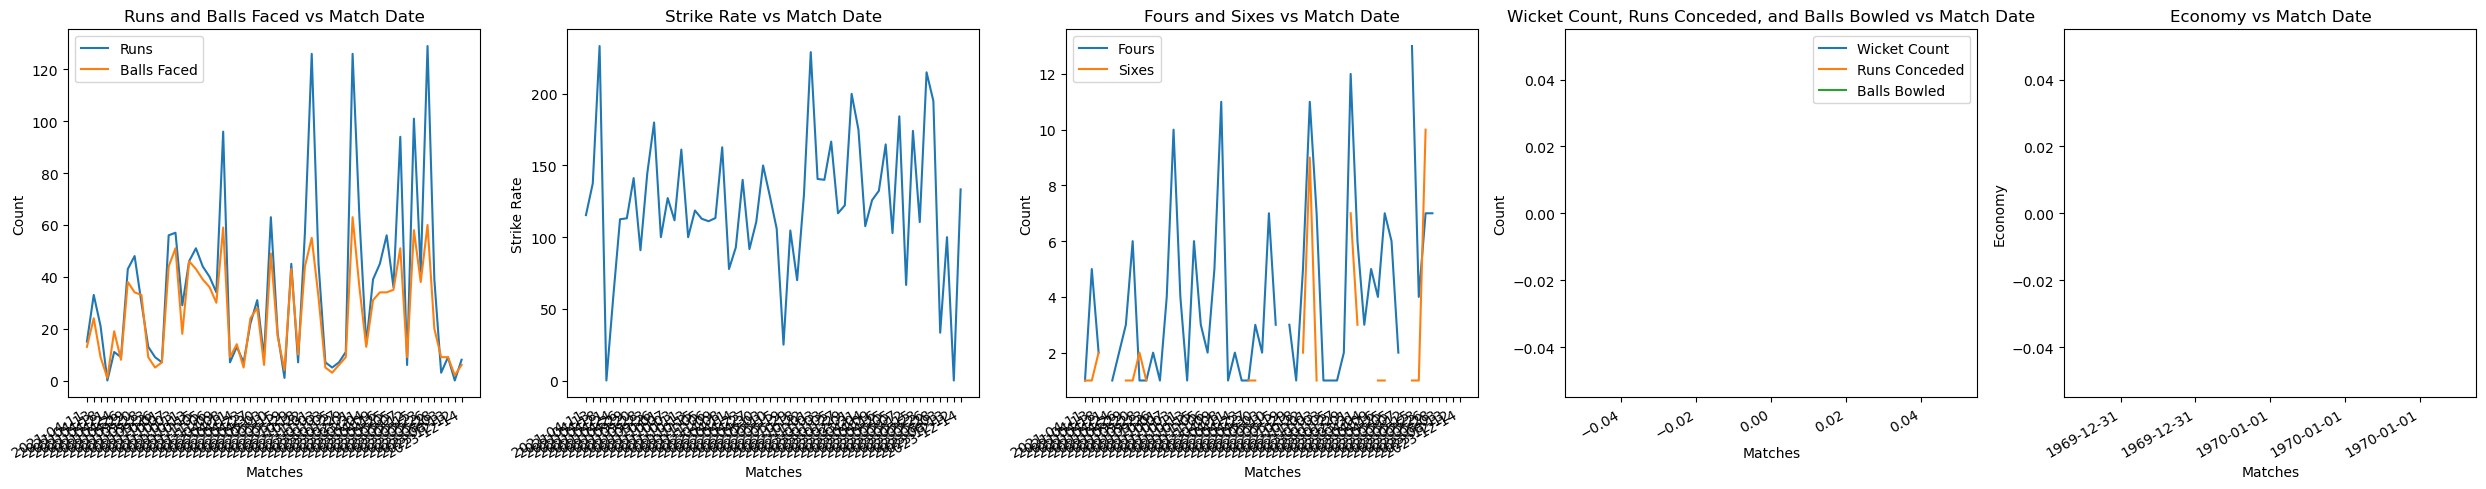

Player ID: 7491224
Batting Performance:
+-------+------------------+------------+--------------------+-------------------+-------------------+--------------------+--------------------+---------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |     match id     | batsman_id | is_batsman_captain | is_batsman_keeper |      inning       |        runs        |    balls_faced     |  over_faced_first   |     bowler_id      | is_bowler_keeper |  is_bowler_captain   |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+------------------+------------+--------------------+-------------------+-------------------+--------------------+--------------------+---------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+------------------

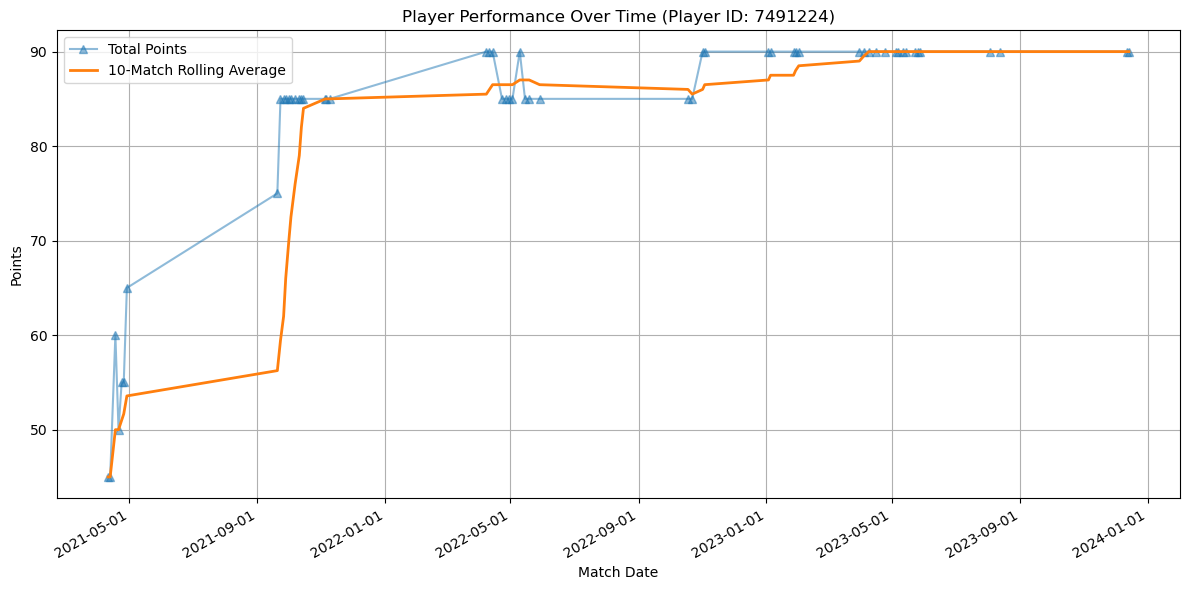

In [22]:
player_perfomance(7491224)

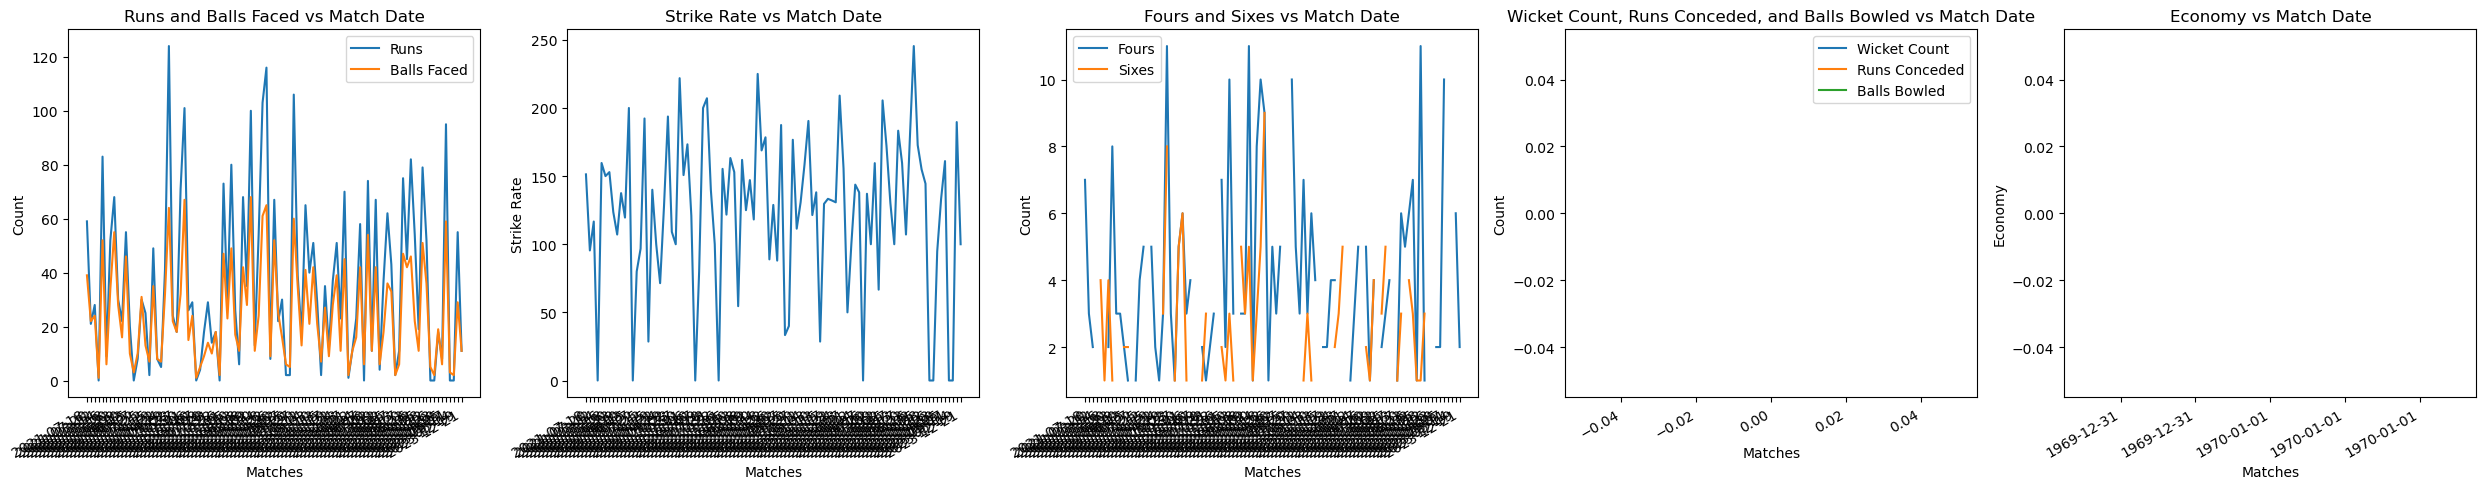

Player ID: 2162782
Batting Performance:
+-------+-------------------+------------+---------------------+---------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain  |  is_batsman_keeper  |       inning       |       runs        |    balls_faced    |  over_faced_first  |     bowler_id      | is_bowler_keeper |  is_bowler_captain   |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+-------------------+------------+---------------------+---------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+------------

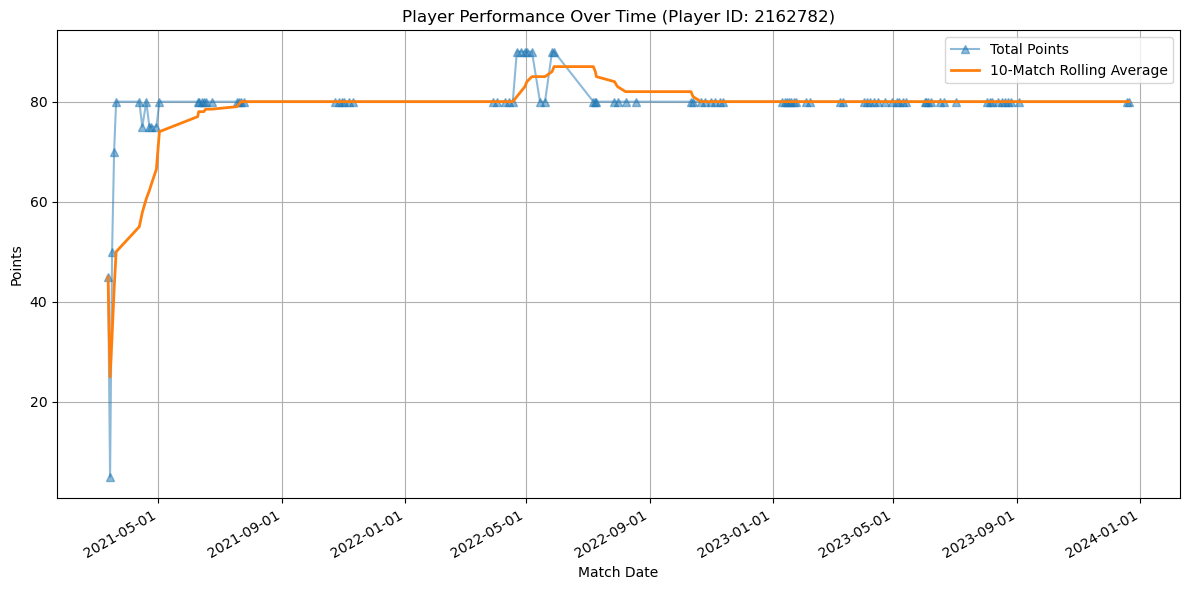

In [23]:
player_perfomance(2162782)

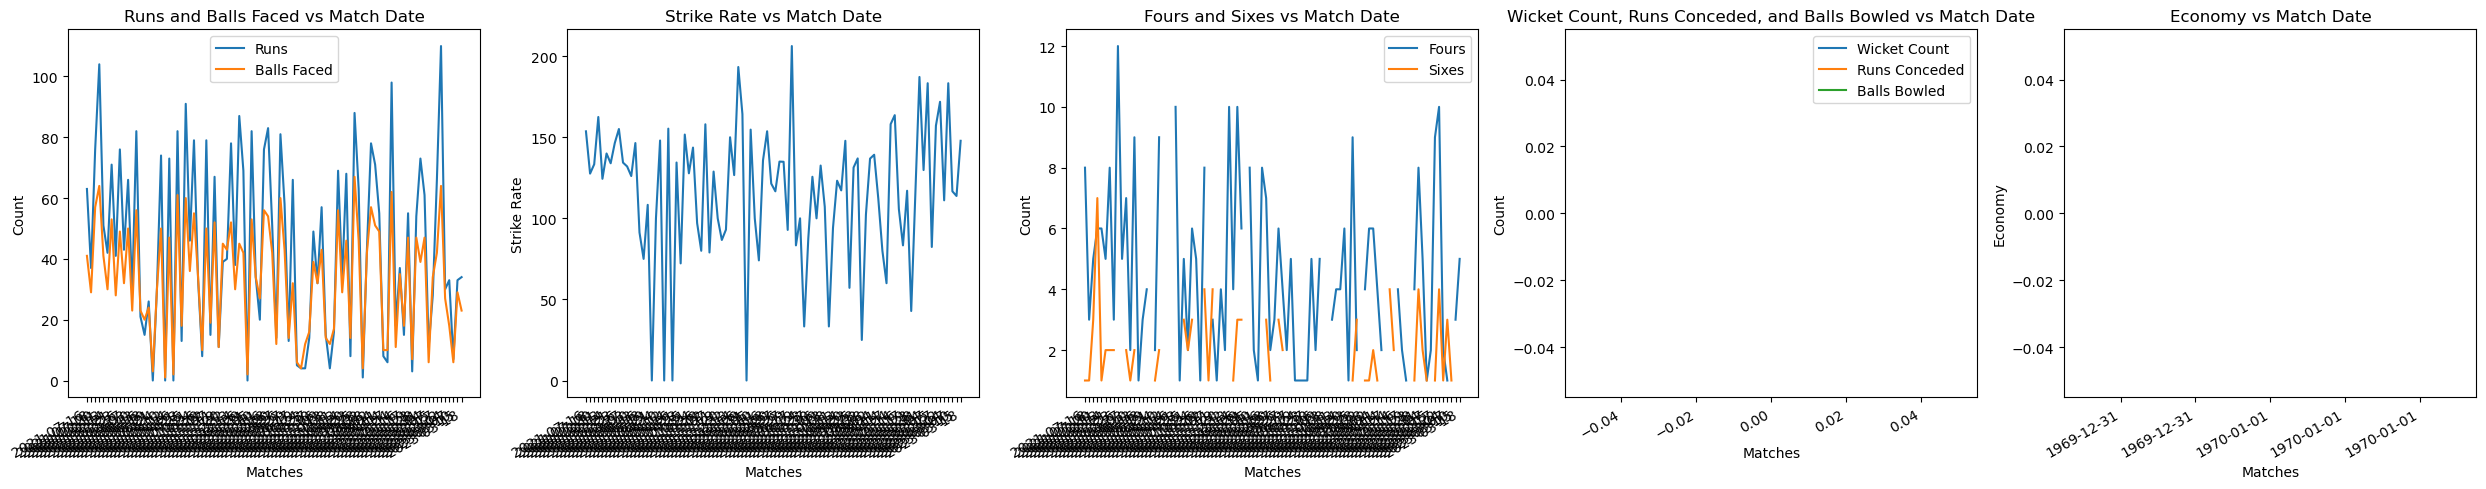

Player ID: 2263736
Batting Performance:
+-------+--------------------+------------+---------------------+---------------------+--------------------+-------------------+--------------------+---------------------+--------------------+------------------+---------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain  |  is_batsman_keeper  |       inning       |       runs        |    balls_faced     |  over_faced_first   |     bowler_id      | is_bowler_keeper |  is_bowler_captain  |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+--------------------+------------+---------------------+---------------------+--------------------+-------------------+--------------------+---------------------+--------------------+------------------+---------------------+--------------------+--------------------+--------------------+------

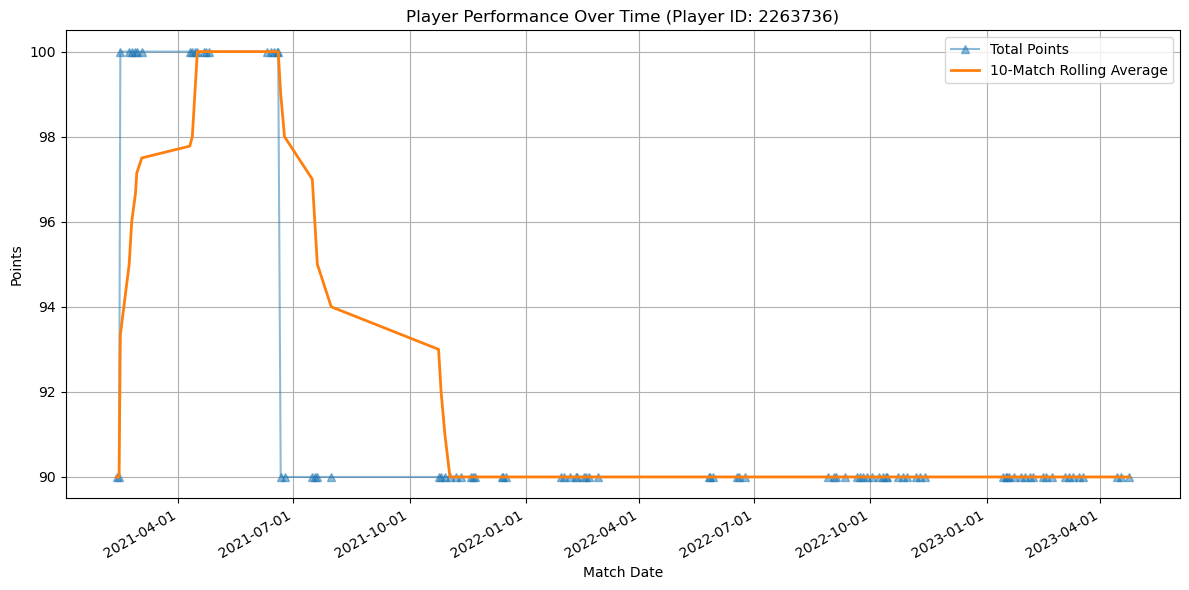

In [24]:
player_perfomance(2263736)

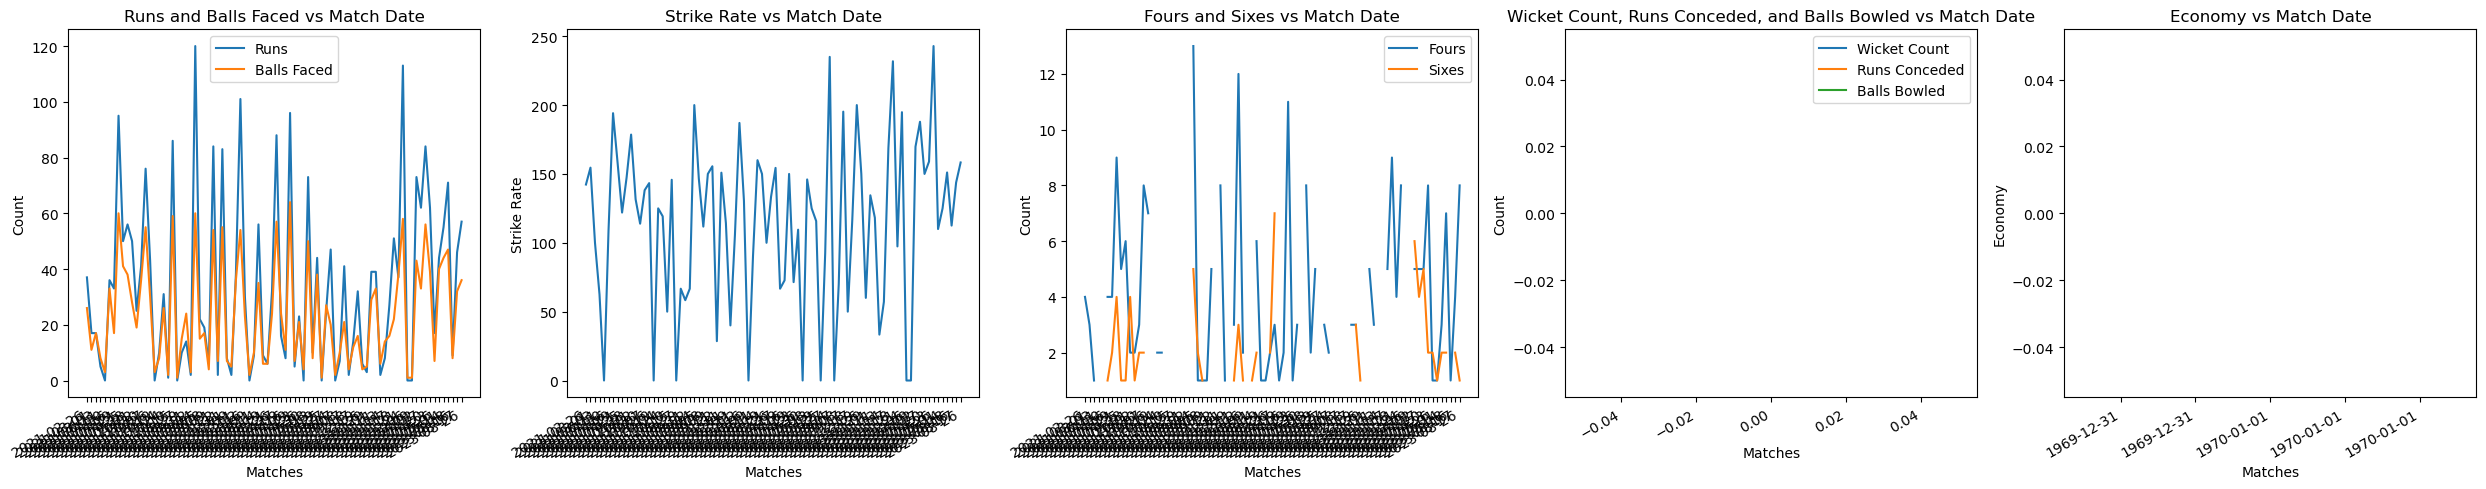

Player ID: 313809
Batting Performance:
+-------+-------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id      | is_bowler_keeper |  is_bowler_captain   |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+-------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+----------------

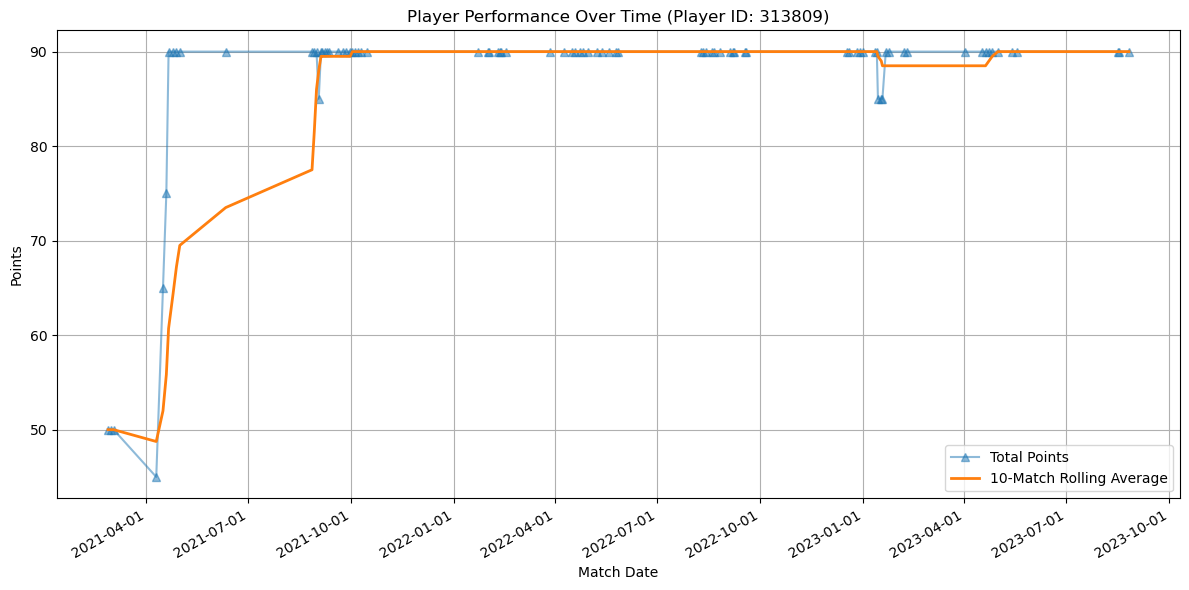

In [25]:
player_perfomance(313809)

**BOWLER SELECTION**

Selecting the highest ranking bowler from the bowler_stats.xlsx - note that we *ONLY* use bowling scores.
* We list out the 15 highest players first. Unlike the batsman stats, we will eliminate the following bowlers due to lack of experience (they have wickets < 10) - they are row 3 to 9. We consider the remaining 8 players.
* First to choose among the top 3 players who have a score of a 110 each. Based on the perfomance vs match dates graph, the first player to be selected is 5595302 due to his consistently high score across most matches (while he has played relatively lesser matches, he has performed better and is consistent).
* 328607 is selected next and after which 2943443 is selected - while not as consistent as the previous bowler, he has a good scoring and score greater than 2943443 in most matches.
* We then consider the next 5 players whose score is 100 each. First we consider 5554254 and 3519011 as they are the most experienced players and have the highest moving average curves. However, we note that based on their bowling strike rate and economy 3519011 narrowly wins over 5554254. So first we select 3519011 and then we select 5554254.
* Next, the most consistent player as per the previous matches average curves is 49496.
* After that comes 284339, who is scoring well but not as consistent as 49496.
* Lastly, we have 4377694.

Final order of selection of bowlers:

1. 5595302 - 110 points
2. 328607 - 110 points
3. 2943443 - 110 points
4. 3519011 - 100 points
5. 5554254 - 100 points
6. 49496 - 100 points
7. 284339 - 100 points
8. 4377694 - 100 points

In [26]:
bowler_stats[:15]

player_id  wickets  bowling_strike_rate   economy  bowling_average  \
0      328607       27            13.733333  5.811200        13.373333   
1     2943443       16            13.500000  5.797143        12.803571   
2     5595302       21            12.727273  5.636364         9.901515   
3     9362702        2            12.000000  3.000000         6.000000   
4     8059015        4             6.000000  5.000000         5.000000   
5     9822392        3             6.000000  2.330000         2.333333   
6     1663920        1             6.000000  2.000000         2.000000   
7     8934764        1             6.000000  2.000000         2.000000   
8     8354800        1             6.000000  3.000000         3.000000   
9     5636658        1             3.000000  0.000000         0.000000   
10    5554254      175            20.654427  6.815938        17.677734   
11    3519011       76            16.929710  6.692174        17.143720   
12     284339       85            14.864550  6.865079        17.756614   
13    4377694       42            14.650000  6.899687        16.781250   
14      49496       31            17.604348  6.203043        16.148551   

    4w_per_innings  is_bowler_keeper  balls_bowled  bowling_points  
0                2                 0           550             110  
1                2                 0           288             110  
2                2                 0           240             110  
3                0                 0            24             110  
4                1                 0            24             110  
5                0                 0            18             110  
6                0                 0             6             110  
7                0                 0             6             110  
8                0                 0             6             110  
9                0                 0             3             110  
10               6                 0          2977             100  
11               2                 0          1517             100  
12               1                 0          1385             100  
13               1                 0           720             100  
14               3                 0           516             100

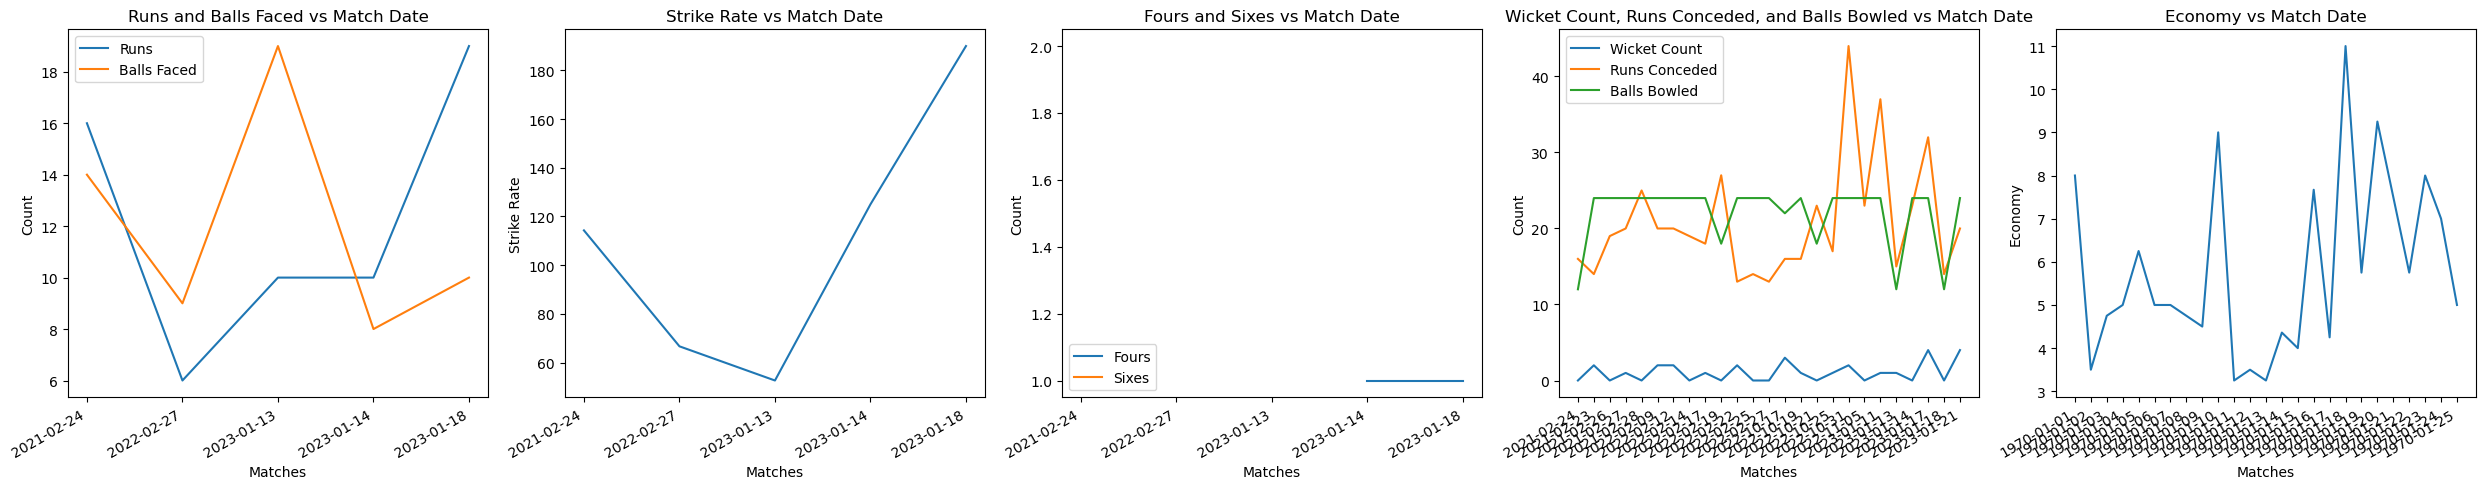

Player ID: 328607
Batting Performance:
+-------+--------------------+------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain | is_batsman_keeper |       inning       |       runs        |    balls_faced    |  over_faced_first  |     bowler_id     | is_bowler_keeper | is_bowler_captain |    strike_rate    |       Fours        | Sixes |      ingestion_timestamp      |
+-------+--------------------+------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------+-------------------------------+
| count |        5.0         |    5.0   

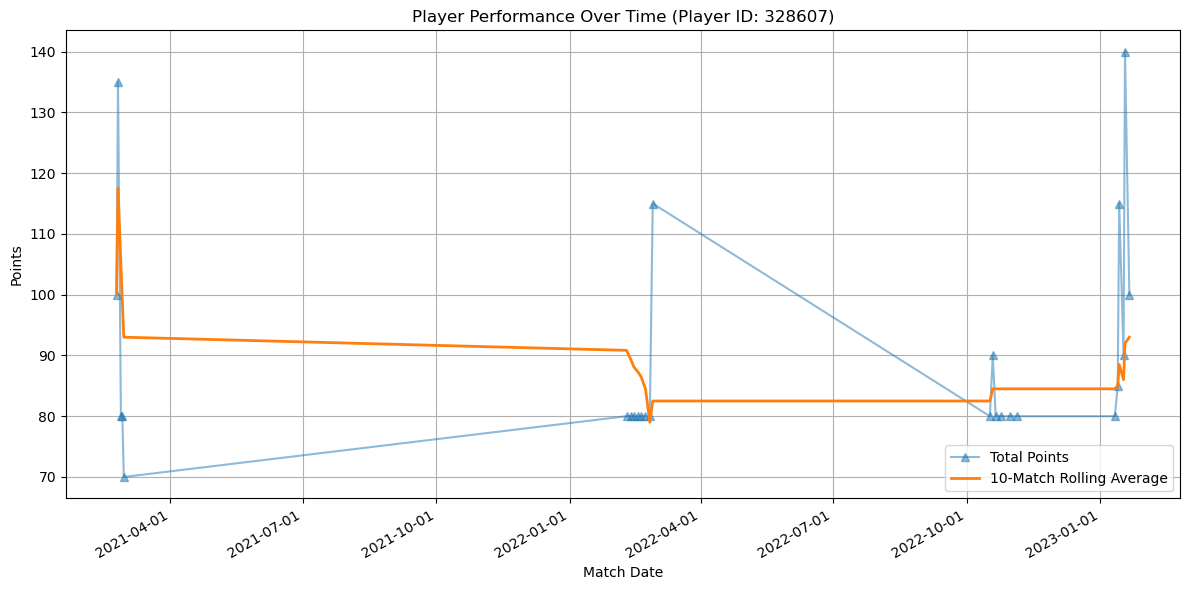

In [27]:
player_perfomance(328607)

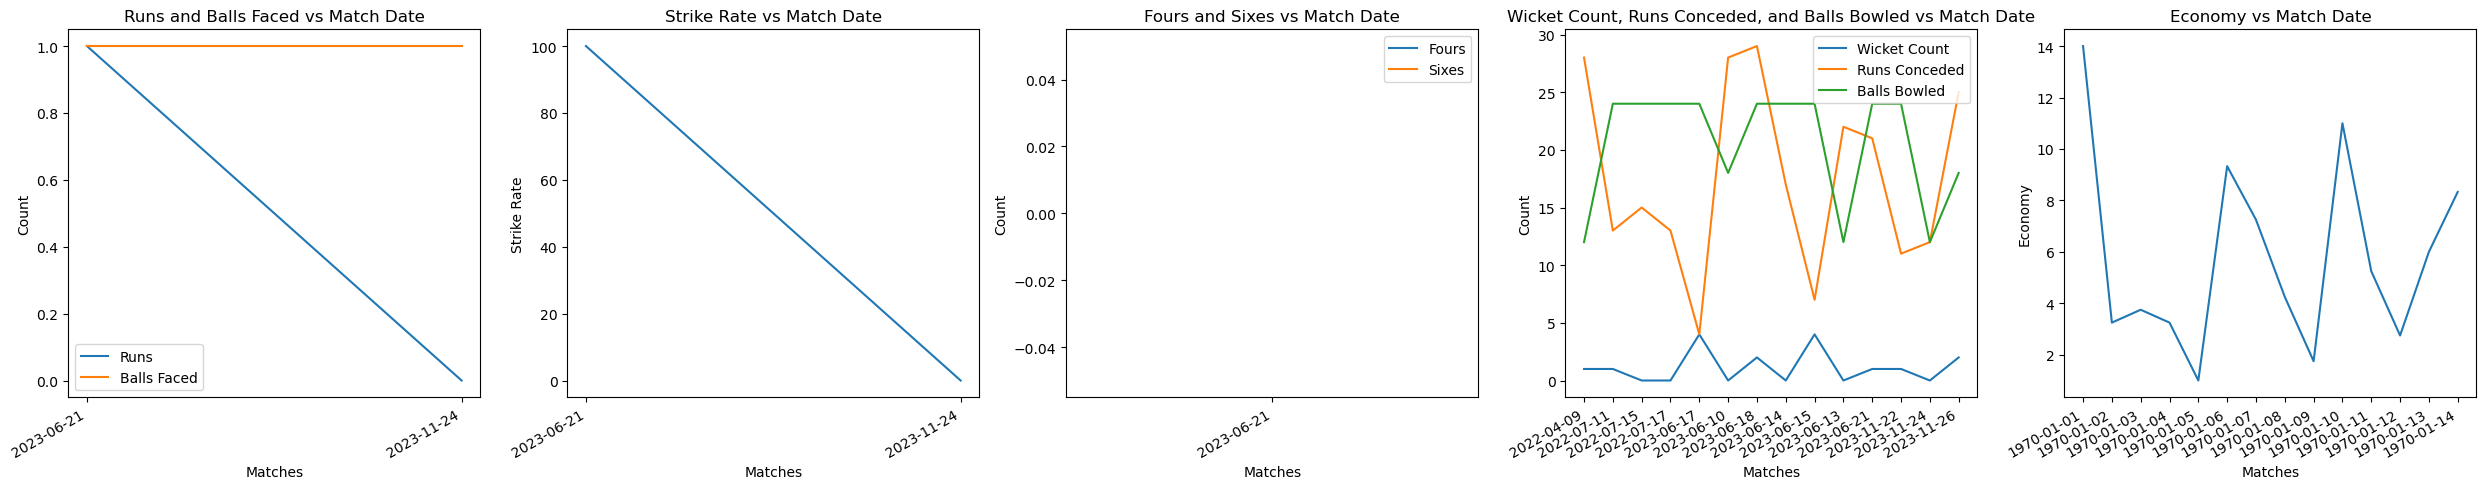

Player ID: 2943443
Batting Performance:
+-------+--------------------+------------+--------------------+-------------------+--------+--------------------+-------------+---------------------+-----------+------------------+-------------------+-------------------+-------+-------+---------------------+
|       |      match id      | batsman_id | is_batsman_captain | is_batsman_keeper | inning |        runs        | balls_faced |  over_faced_first   | bowler_id | is_bowler_keeper | is_bowler_captain |    strike_rate    | Fours | Sixes | ingestion_timestamp |
+-------+--------------------+------------+--------------------+-------------------+--------+--------------------+-------------+---------------------+-----------+------------------+-------------------+-------------------+-------+-------+---------------------+
| count |        2.0         |    2.0     |        2.0         |        2.0        |  2.0   |        2.0         |     2.0     |         2.0         |    1.0    |       1.0        

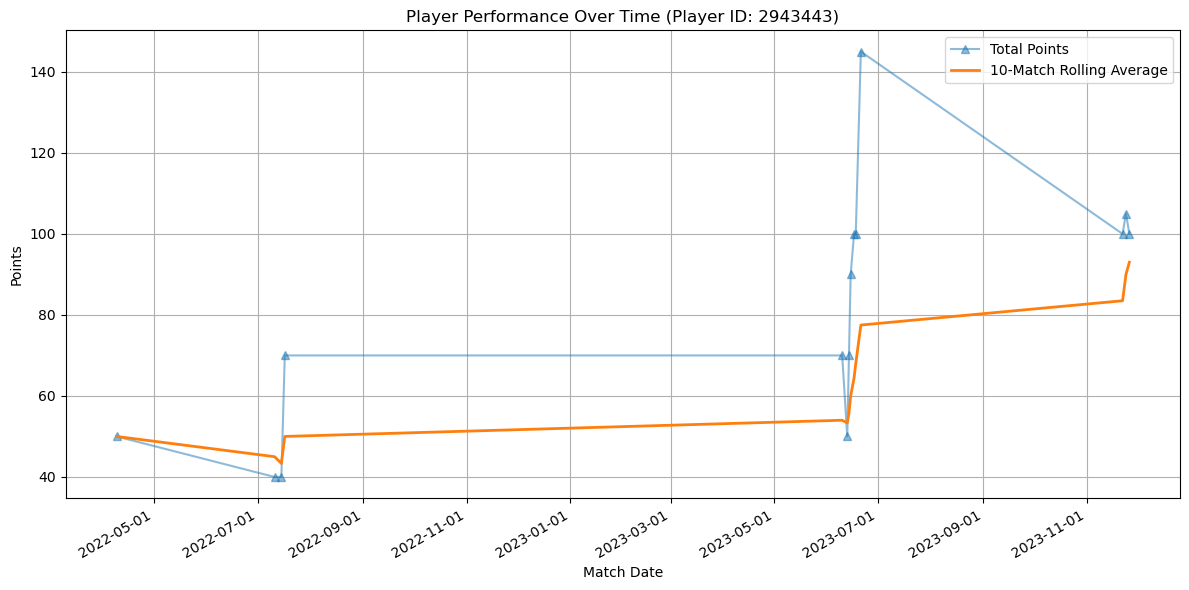

In [28]:
player_perfomance(2943443)

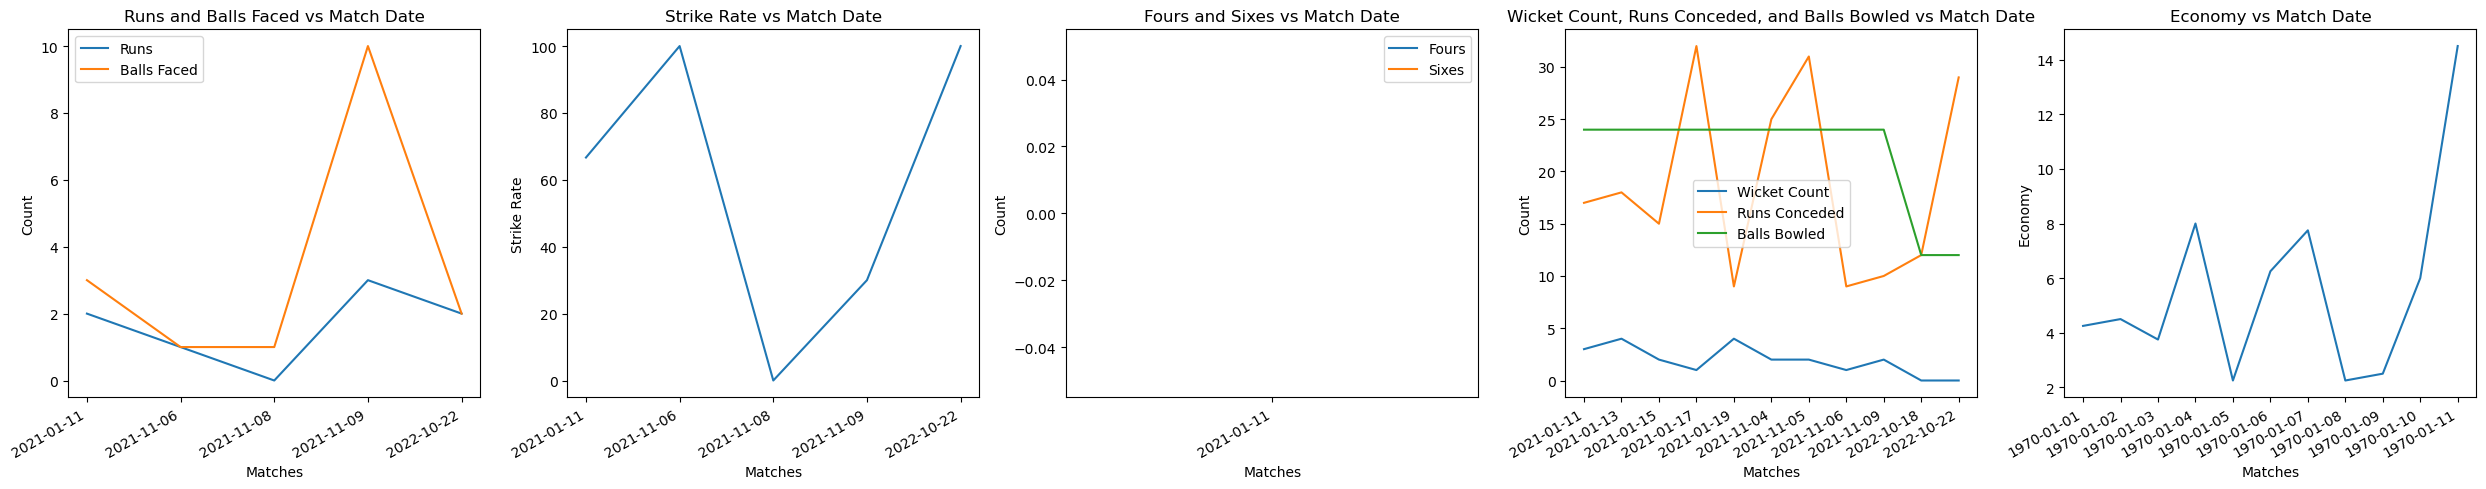

Player ID: 5595302
Batting Performance:
+-------+--------------------+------------+--------------------+-------------------+--------+-------------------+--------------------+--------------------+-----------+------------------+-------------------+--------------------+-------+-------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain | is_batsman_keeper | inning |       runs        |    balls_faced     |  over_faced_first  | bowler_id | is_bowler_keeper | is_bowler_captain |    strike_rate     | Fours | Sixes |      ingestion_timestamp      |
+-------+--------------------+------------+--------------------+-------------------+--------+-------------------+--------------------+--------------------+-----------+------------------+-------------------+--------------------+-------+-------+-------------------------------+
| count |        5.0         |    5.0     |        5.0         |        5.0        |  5.0   |        5.0        |        5.0        

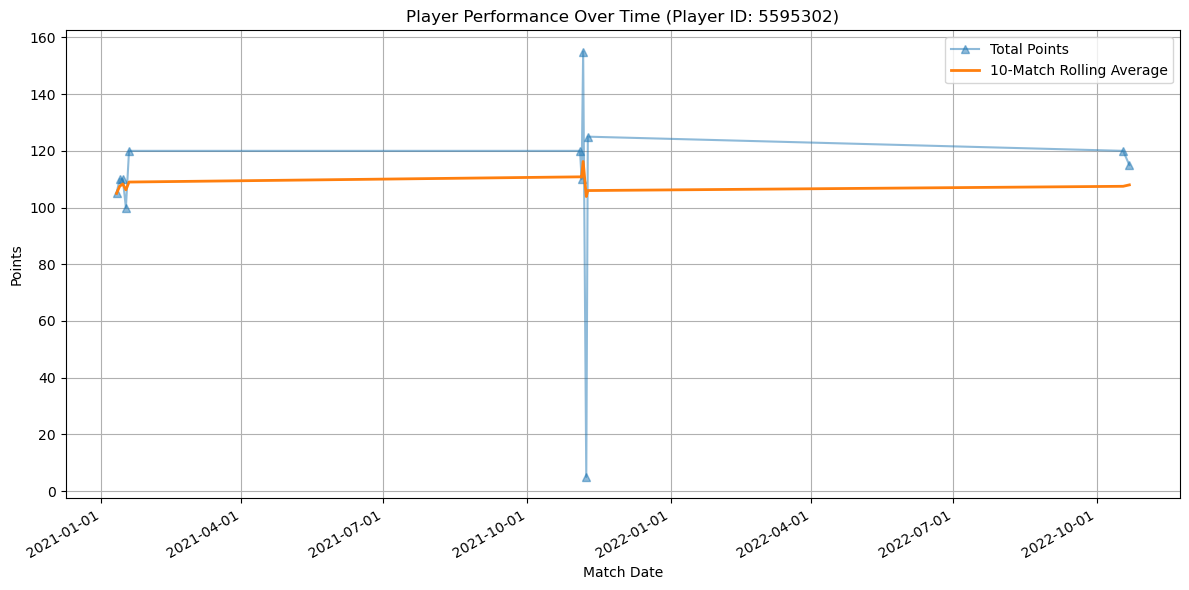

In [29]:
player_perfomance(5595302)

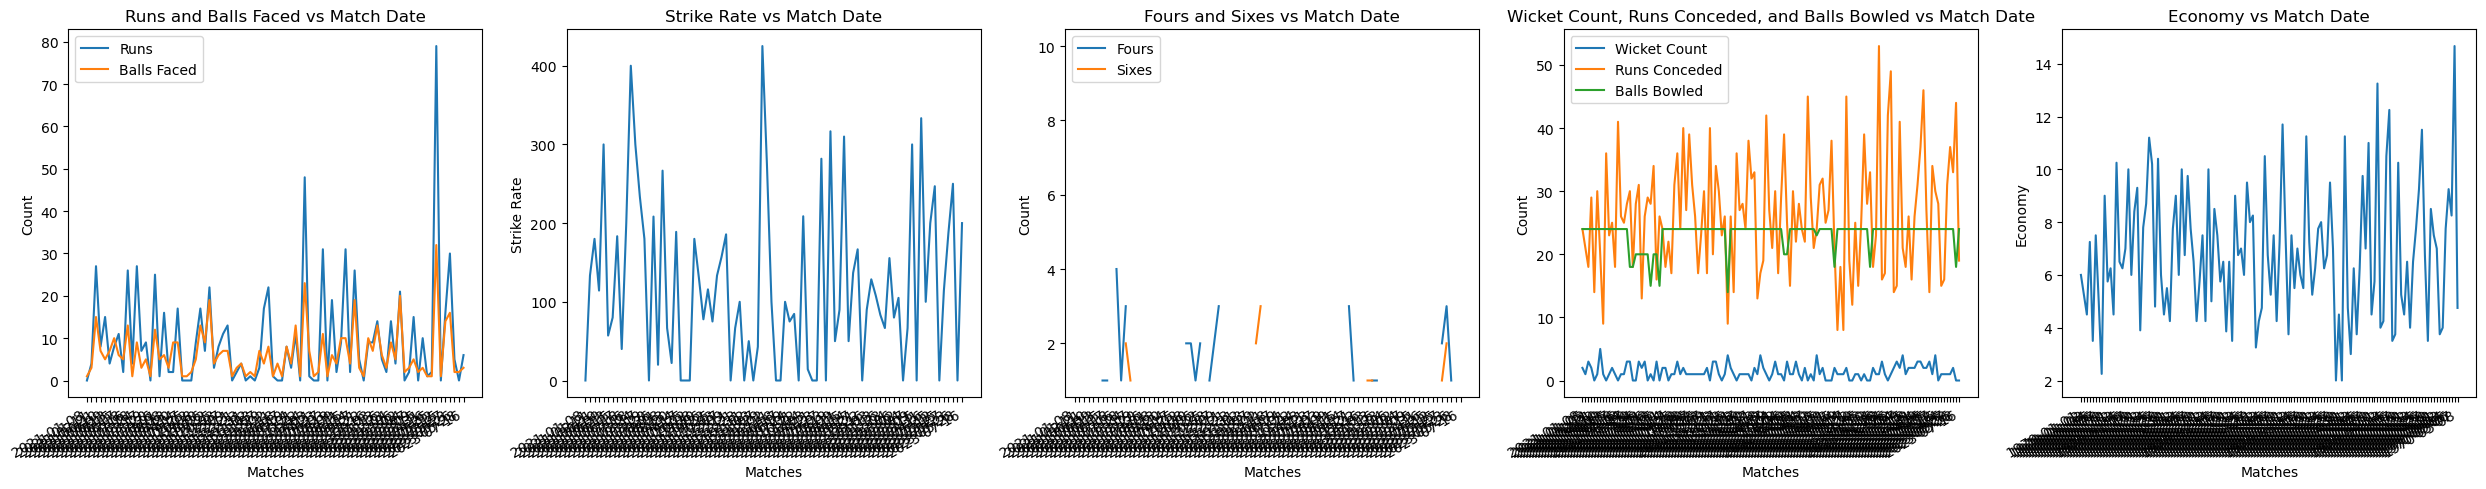

Player ID: 5554254
Batting Performance:
+-------+-------------------+------------+---------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+---------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain  | is_batsman_keeper |       inning       |       runs        |    balls_faced    |  over_faced_first  |     bowler_id      | is_bowler_keeper |  is_bowler_captain  |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+-------------------+------------+---------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+---------------------+--------------------+--------------------+--------------------+---------------------

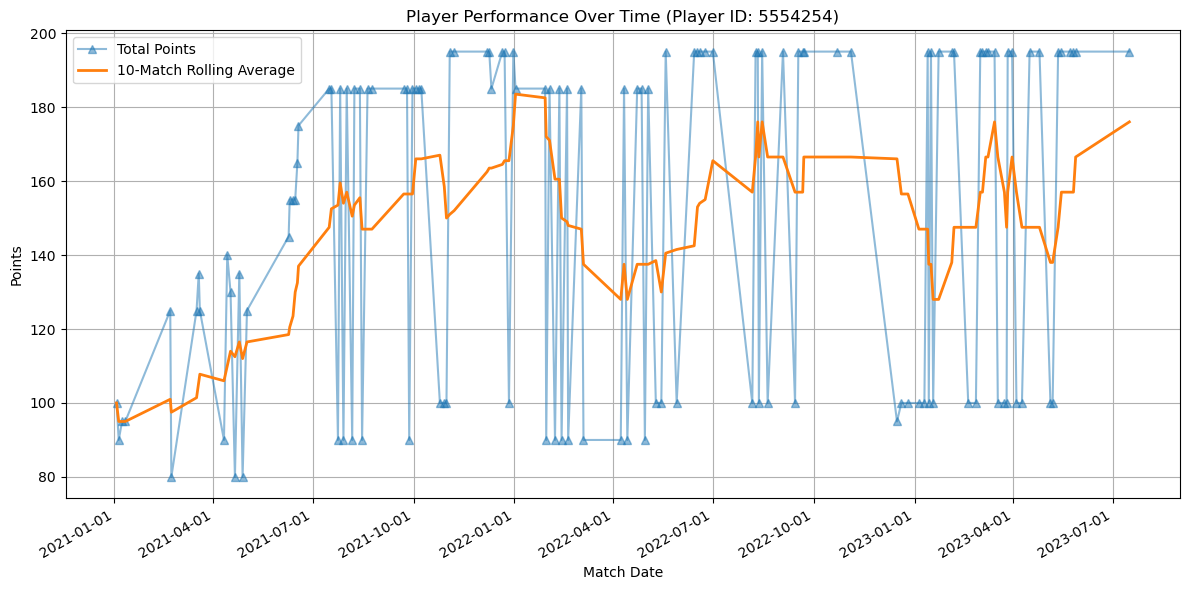

In [30]:
player_perfomance(5554254)

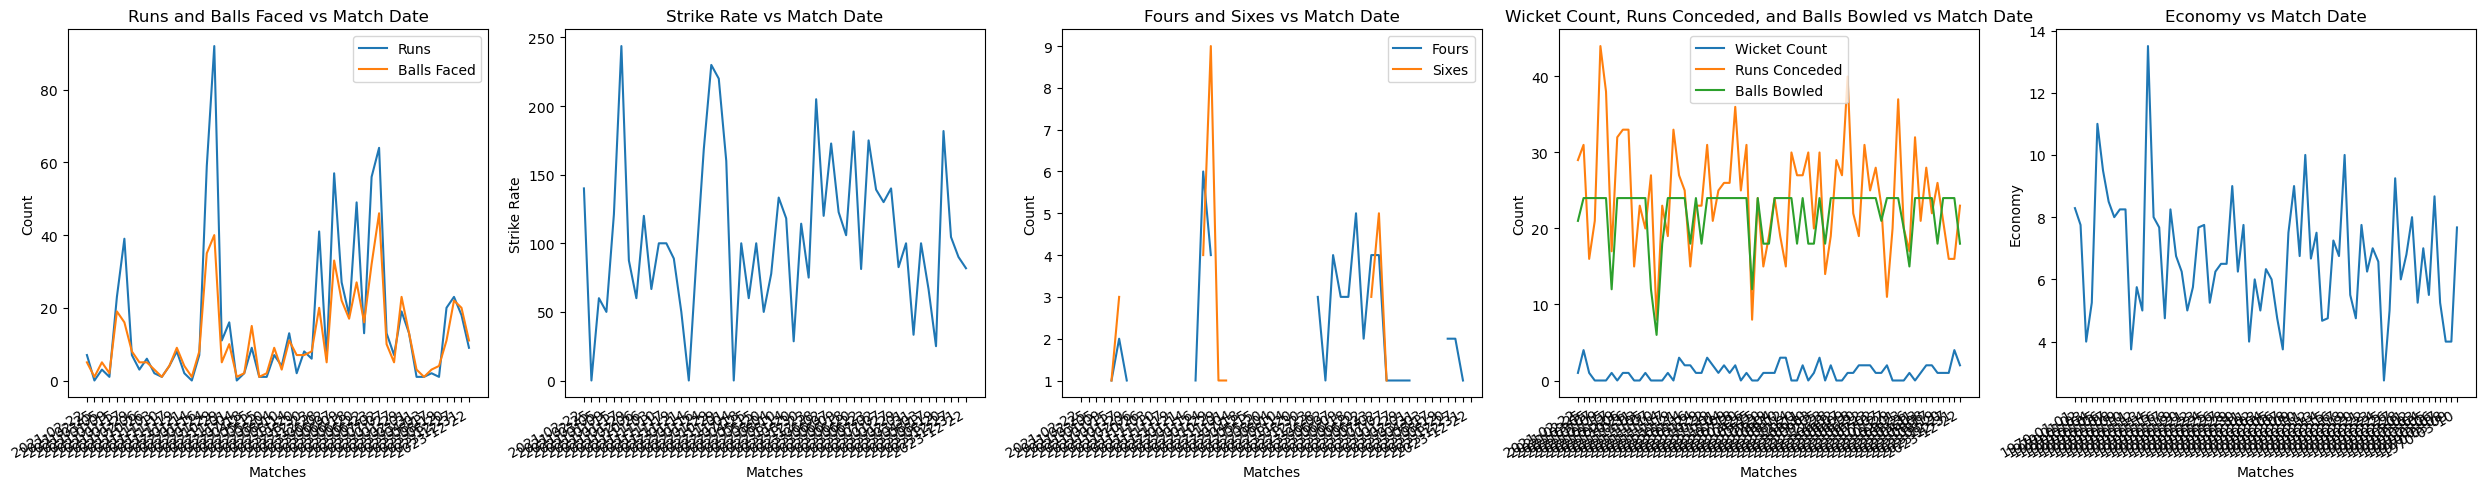

Player ID: 3519011
Batting Performance:
+-------+-------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+-------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain  | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id     | is_bowler_keeper |  is_bowler_captain  |    strike_rate     |       Fours        |       Sixes       |      ingestion_timestamp      |
+-------+-------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+-------------------+---------------------

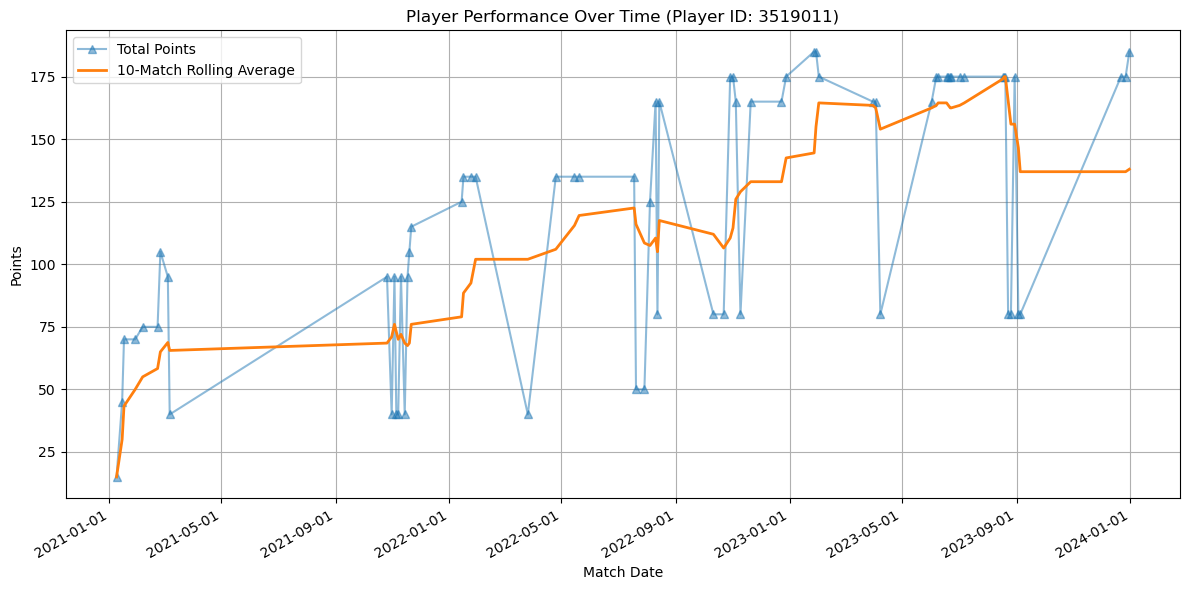

In [31]:
player_perfomance(3519011)

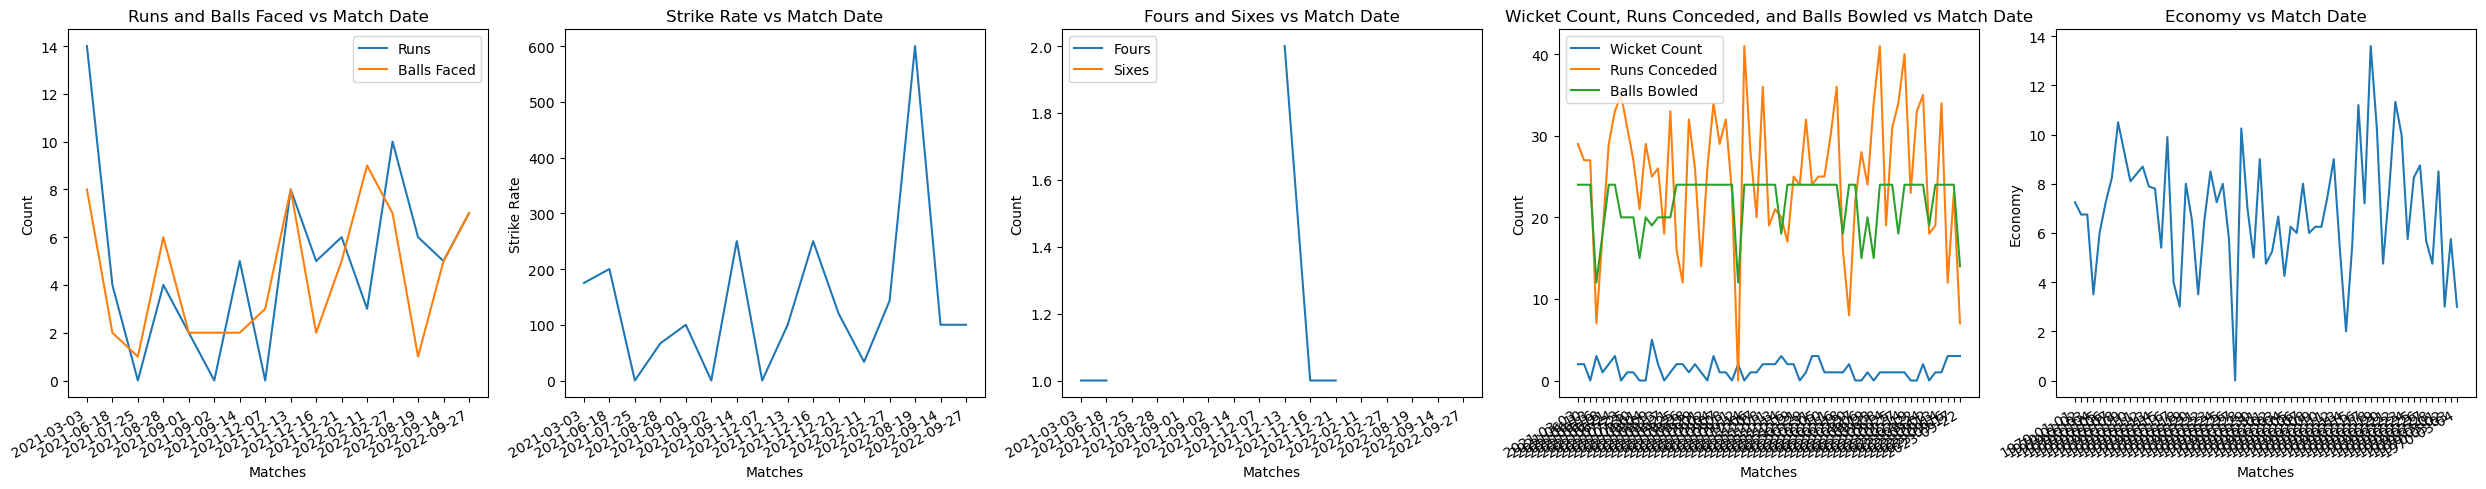

Player ID: 284339
Batting Performance:
+-------+--------------------+------------+--------------------+-------------------+------------------+--------+------------------+--------------------+--------------------+------------------+-------------------+-------------------+--------------------+-------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain | is_batsman_keeper |      inning      |  runs  |   balls_faced    |  over_faced_first  |     bowler_id      | is_bowler_keeper | is_bowler_captain |    strike_rate    |       Fours        | Sixes |      ingestion_timestamp      |
+-------+--------------------+------------+--------------------+-------------------+------------------+--------+------------------+--------------------+--------------------+------------------+-------------------+-------------------+--------------------+-------+-------------------------------+
| count |        16.0        |    16.0    |        16.0        |       16.0    

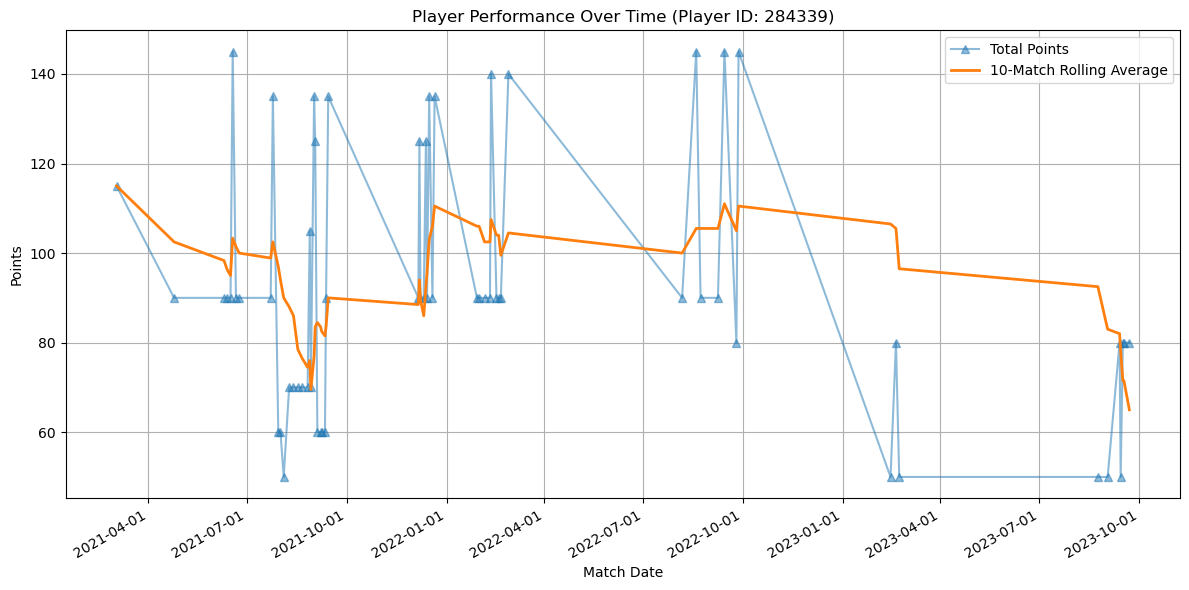

In [32]:
player_perfomance(284339)

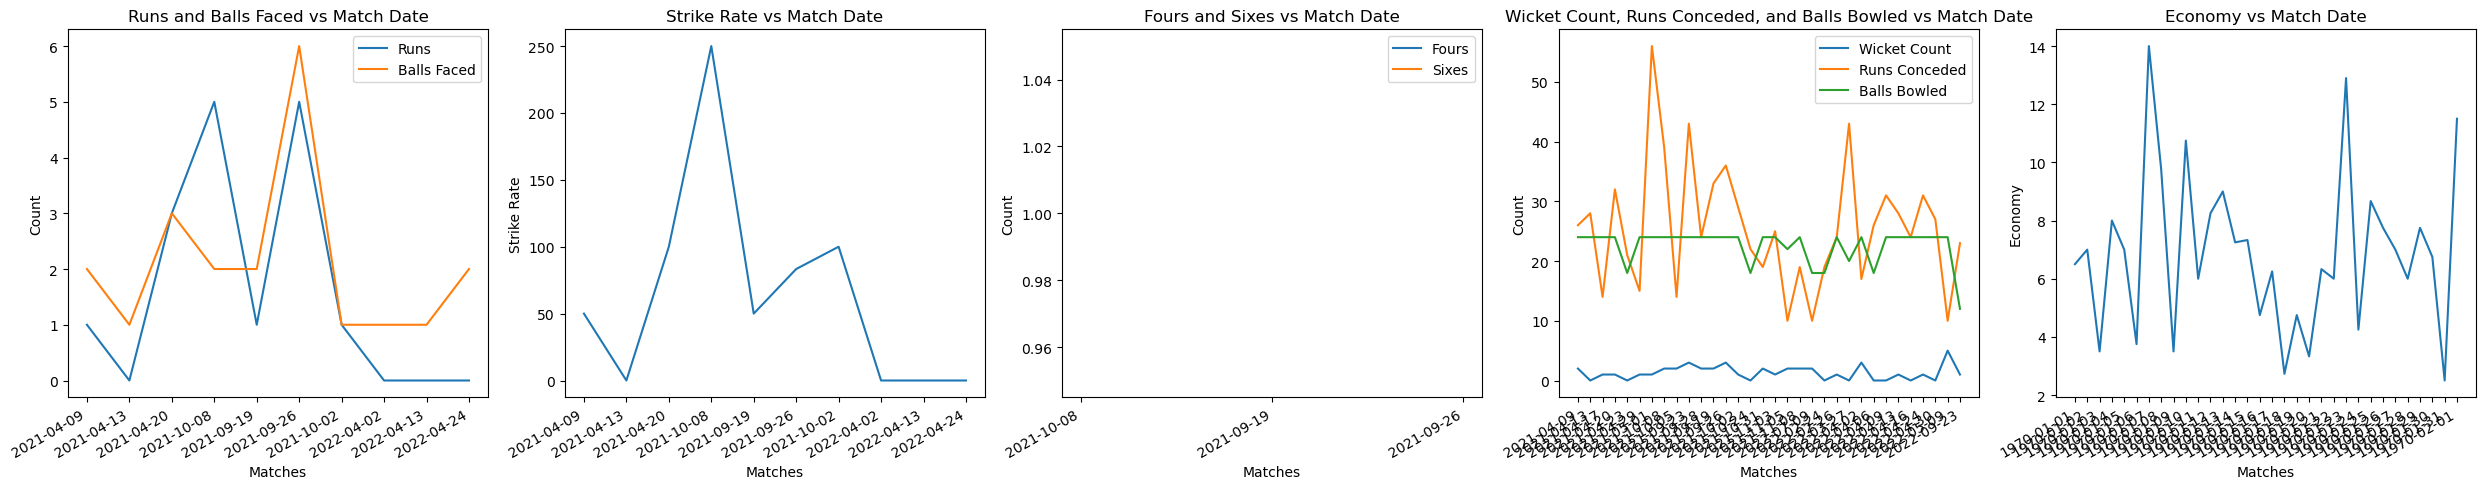

Player ID: 4377694
Batting Performance:
+-------+-------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------+-------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id     | is_bowler_keeper | is_bowler_captain |    strike_rate    | Fours | Sixes |      ingestion_timestamp      |
+-------+-------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------+-------+-------------------------------+
| count |       10.0        |    10.0    |        10.0        |       10.0 

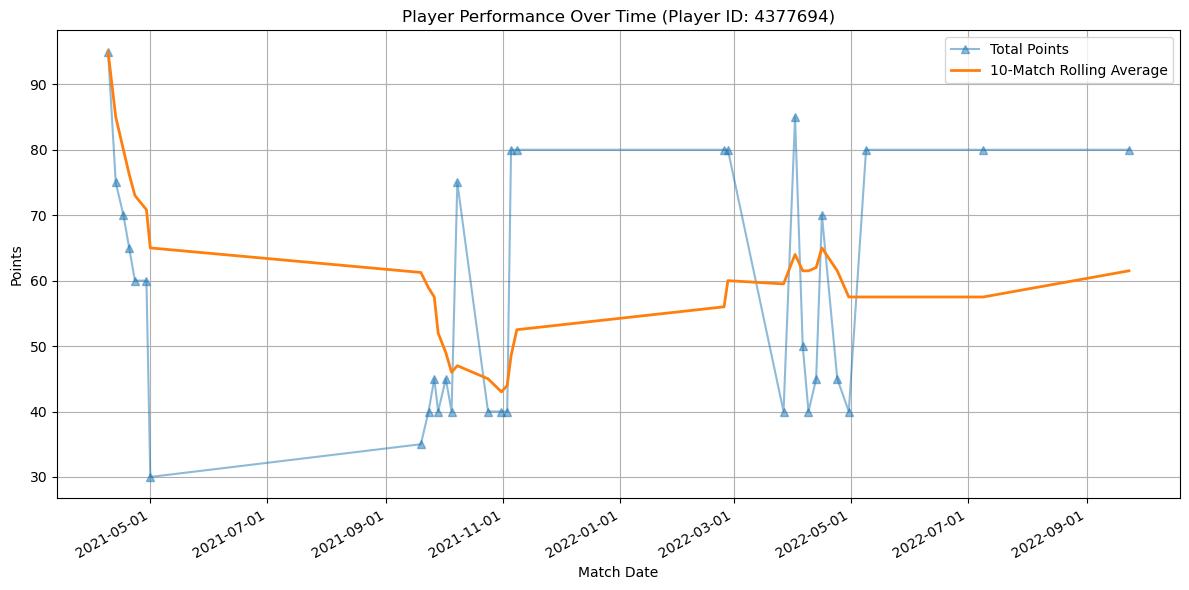

In [33]:
player_perfomance(4377694)

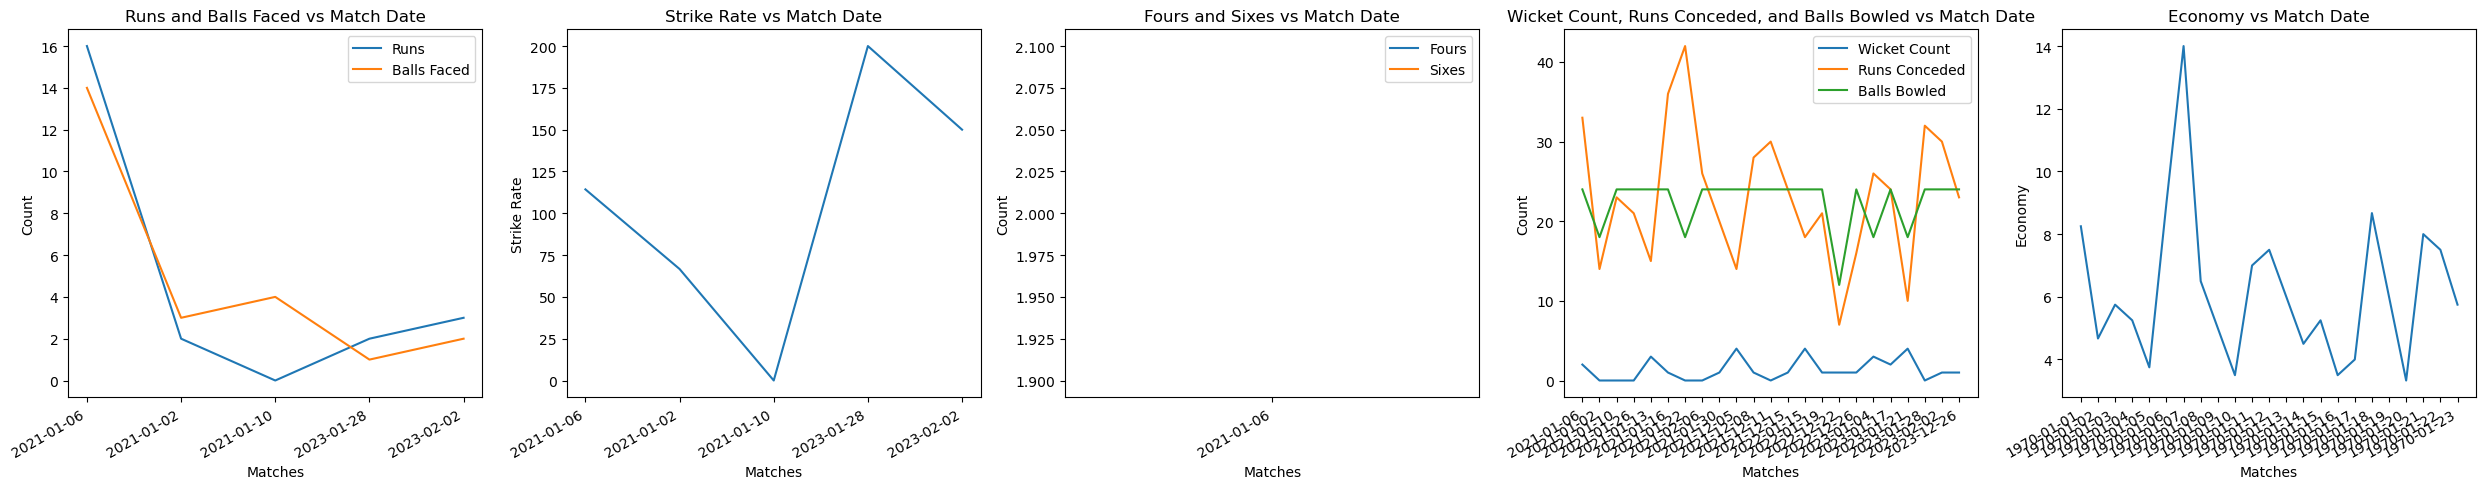

Player ID: 49496
Batting Performance:
+-------+--------------------+------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------+-------+---------------------+
|       |      match id      | batsman_id | is_batsman_captain | is_batsman_keeper |       inning       |       runs        |    balls_faced    |  over_faced_first  |     bowler_id      | is_bowler_keeper | is_bowler_captain |    strike_rate     | Fours | Sixes | ingestion_timestamp |
+-------+--------------------+------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------+-------+---------------------+
| count |        5.0         |    5.0     |        5.0         |        5.0        |        5.0         

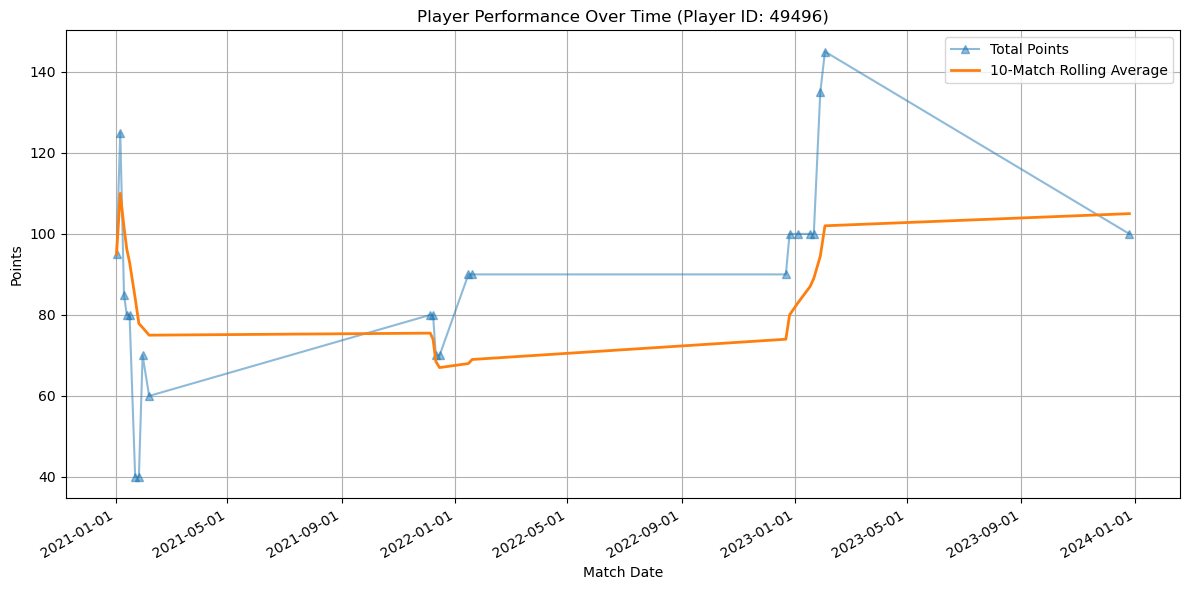

In [34]:
player_perfomance(49496)

**OVERALL SELECTION**

Selecting the highest ranking players from the merged_player_stats.xlsx - note that we use *BOTH* batting and bowling scores. This listing is mainly being used to find the best all rounders.

* We list out the 17 highest players first. We first of all filter out players unfit to be all rounders - these are the players in row 0,5,6,7,10,14. We also reject 251509 (row 1) - while he is one of the highest point scorers, he has only played 3 matches which contributes to artificially inflating his statistics. Similarly, we reject 7570079 (row 8) and 8354800 (row 14) for playing very played very few matches (<10).
* We then consider the next 3 players with a score of 165 each. 3298427 is selected first for a better perfomance both in terms of recency and average strike rates. Next is 3519011, followed by 2124002, based on the same metric.
* Next, we consider all those with 155 points. Again, based on the perfomance vs match date graph, we rank 4640824 on top followed by 2275195. Next comes 5490582 based on the same criteria.
* This is followed by 328607. 41740 follows due to better averages as compared to 8127230.

Final order of selection of players based on overall statistics:

1. 3298427 - 165 points
2. 3519011 - 165 points
3. 2124002 - 165 points
4. 4640824 - 155 points
5. 2275195 - 155 points
6. 5490582 - 155 points
7. 328607 - 155 points
8. 41740 - 155 points
9. 8127230 - 155 points

In [35]:
merged_stats[:17]

player_id    runs  batting_strike_rate  batting_average  100s   50s  \
0     8934764    88.0           160.096667        29.333333   0.0   1.0   
1      251509    42.0           190.910000        42.000000   0.0   0.0   
2     3519011   802.0           104.809231        15.423077   0.0   5.0   
3     2124002  1683.0           122.781096        23.054795   1.0   9.0   
4     3298427   762.0           111.541613        24.580645   0.0   5.0   
5     5636658   320.0           132.366667        26.666667   0.0   2.0   
6     7586963     7.0           150.000000         3.500000   0.0   0.0   
7     4175772     9.0           150.000000         3.000000   0.0   0.0   
8     7570079    21.0           175.000000        21.000000   0.0   0.0   
9     5490582  1085.0           106.265510        22.142857   0.0   6.0   
10    2980515     7.0           233.330000         7.000000   0.0   0.0   
11    2275195  2480.0           126.458211        26.105263   3.0  14.0   
12    8127230   823.0           112.847273        24.939394   0.0   6.0   
13     328607    61.0           109.718000        12.200000   0.0   0.0   
14    8354800   119.0           121.446000        23.800000   0.0   0.0   
15    4640824  1273.0           119.114795        17.438356   0.0   8.0   
16      41740   976.0           116.654878        23.804878   0.0   6.0   

    is_batsman_keeper  batting_points  wickets  bowling_strike_rate   economy  \
0                 0.0            60.0      1.0             6.000000  2.000000   
1                 0.0            70.0      5.0            13.000000  3.333333   
2                 0.0            65.0     76.0            16.929710  6.692174   
3                 0.0            75.0      3.0             7.500000  6.973333   
4                 0.0            65.0     23.0             9.782609  6.833043   
5                 0.0            50.0      1.0             3.000000  0.000000   
6                 0.0            55.0      3.0            15.000000  4.710000   
7                 0.0            55.0     14.0            13.500000  6.772727   
8                 0.0            55.0      2.0             6.000000  3.500000   
9                 0.0            65.0      3.0            12.600000  6.775000   
10                0.0            55.0      2.0            12.000000  4.250000   
11                0.0            95.0     36.0            12.551471  8.365588   
12                0.0            65.0      2.0             9.000000  6.500000   
13                0.0            45.0     27.0            13.733333  5.811200   
14                0.0            45.0      1.0             6.000000  3.000000   
15                0.0            65.0     96.0            13.869732  8.940460   
16                0.0            65.0      5.0             6.200000  5.900000   

    bowling_average  4w_per_innings  is_bowler_keeper  balls_bowled  \
0          2.000000             0.0               0.0           6.0   
1          8.500000             0.0               0.0          60.0   
2         17.143720             2.0               0.0        1517.0   
3          5.000000             0.0               0.0         166.0   
4          9.097826             1.0               0.0         352.0   
5          0.000000             0.0               0.0           3.0   
6         12.250000             0.0               0.0          42.0   
7         14.545455             1.0               0.0         246.0   
8          3.500000             0.0               0.0          12.0   
9         13.200000             0.0               0.0          98.0   
10         8.500000             0.0               0.0          24.0   
11        13.686275             0.0               0.0         882.0   
12        12.000000             0.0               0.0          18.0   
13        13.373333             2.0               0.0         550.0   
14         3.000000             0.0               0.0           6.0   
15        19.503257             5.0               0.0     

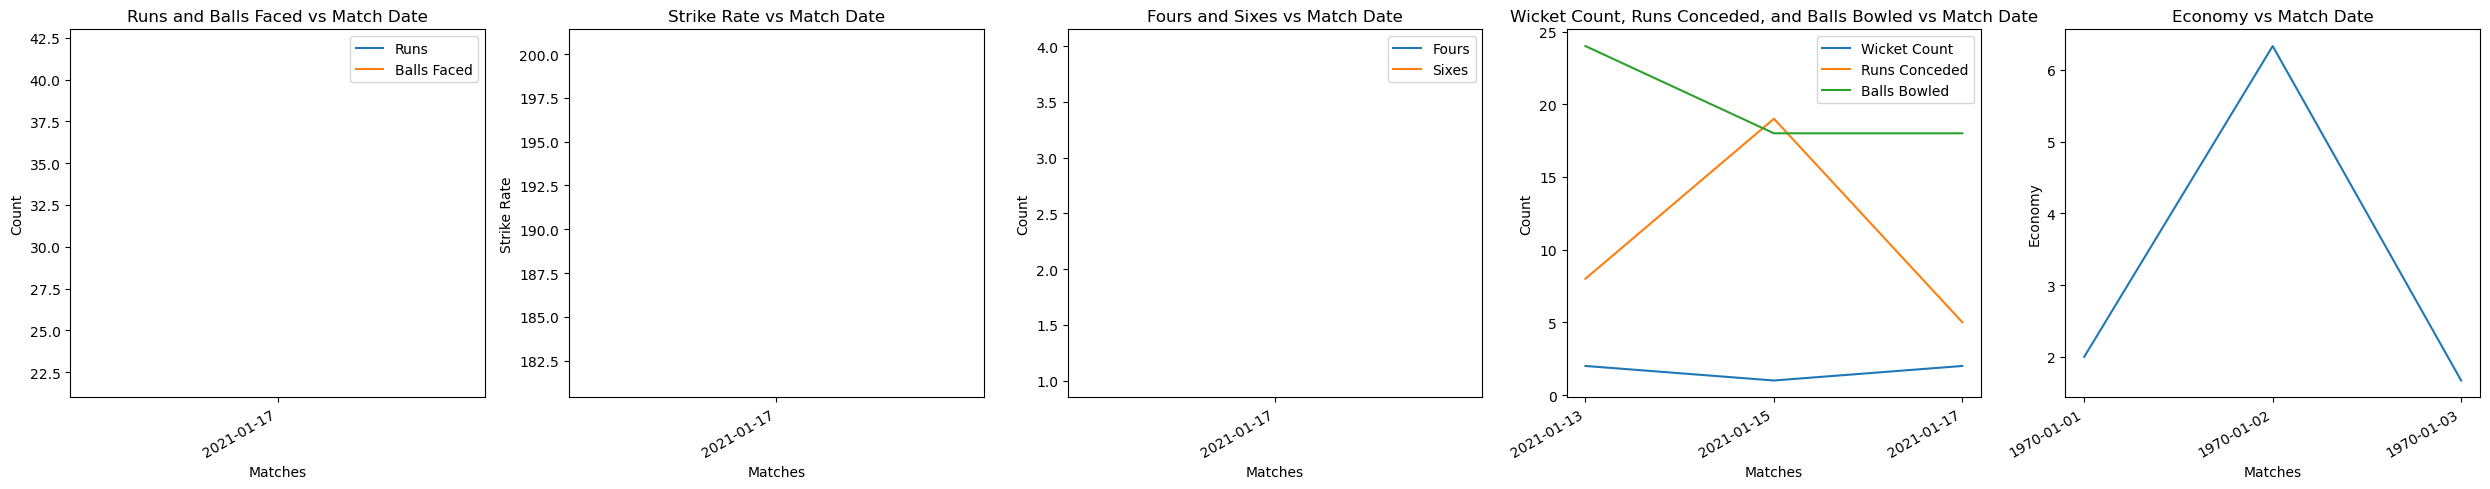

Player ID: 251509
Batting Performance:
+-------+-----------+------------+--------------------+-------------------+--------+------+-------------+------------------+-----------+------------------+-------------------+-------------+-------+-------+---------------------+
|       | match id  | batsman_id | is_batsman_captain | is_batsman_keeper | inning | runs | balls_faced | over_faced_first | bowler_id | is_bowler_keeper | is_bowler_captain | strike_rate | Fours | Sixes | ingestion_timestamp |
+-------+-----------+------------+--------------------+-------------------+--------+------+-------------+------------------+-----------+------------------+-------------------+-------------+-------+-------+---------------------+
| count |    1.0    |    1.0     |        1.0         |        1.0        |  1.0   | 1.0  |     1.0     |       1.0        |    1.0    |       1.0        |        1.0        |     1.0     |  1.0  |  1.0  |          1          |
| mean  | 8710673.0 |  251509.0  |        0.0    

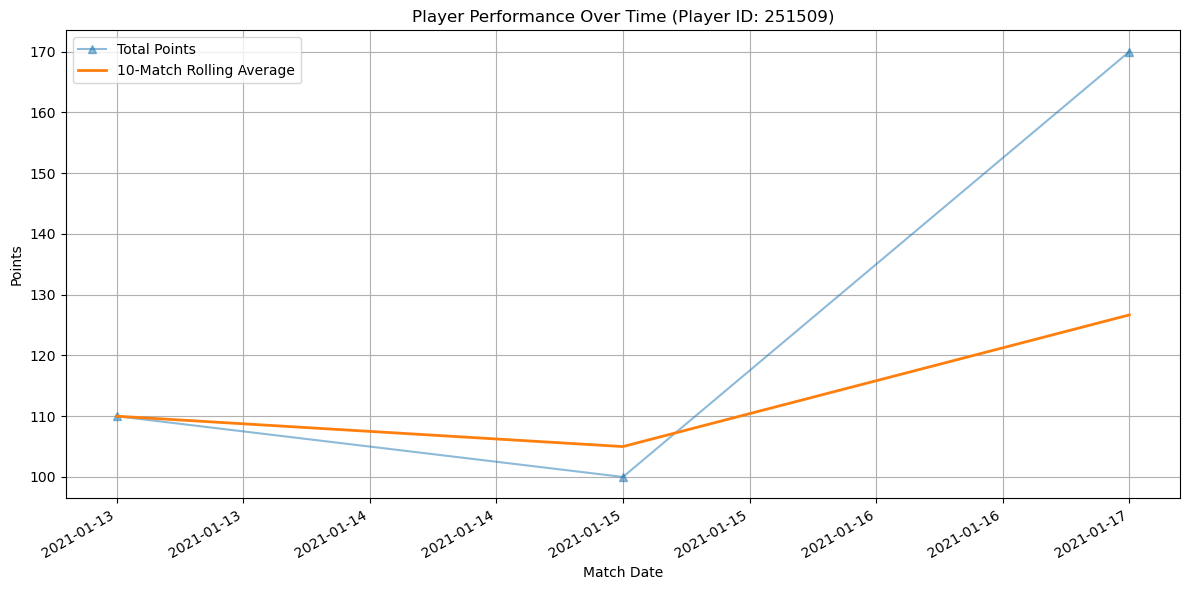

In [36]:
player_perfomance(251509)

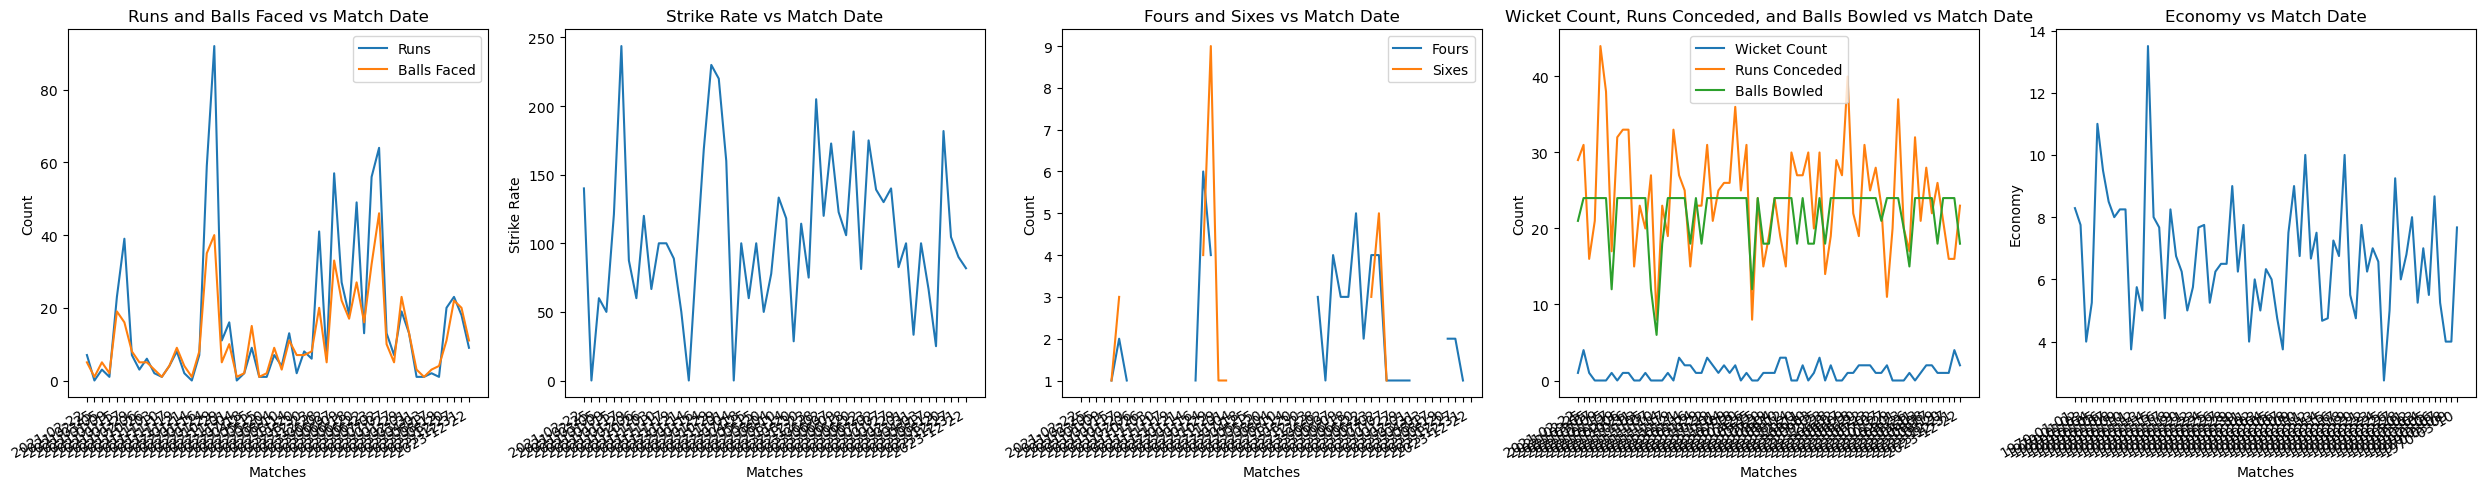

Player ID: 3519011
Batting Performance:
+-------+-------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+-------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain  | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id     | is_bowler_keeper |  is_bowler_captain  |    strike_rate     |       Fours        |       Sixes       |      ingestion_timestamp      |
+-------+-------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+-------------------+---------------------

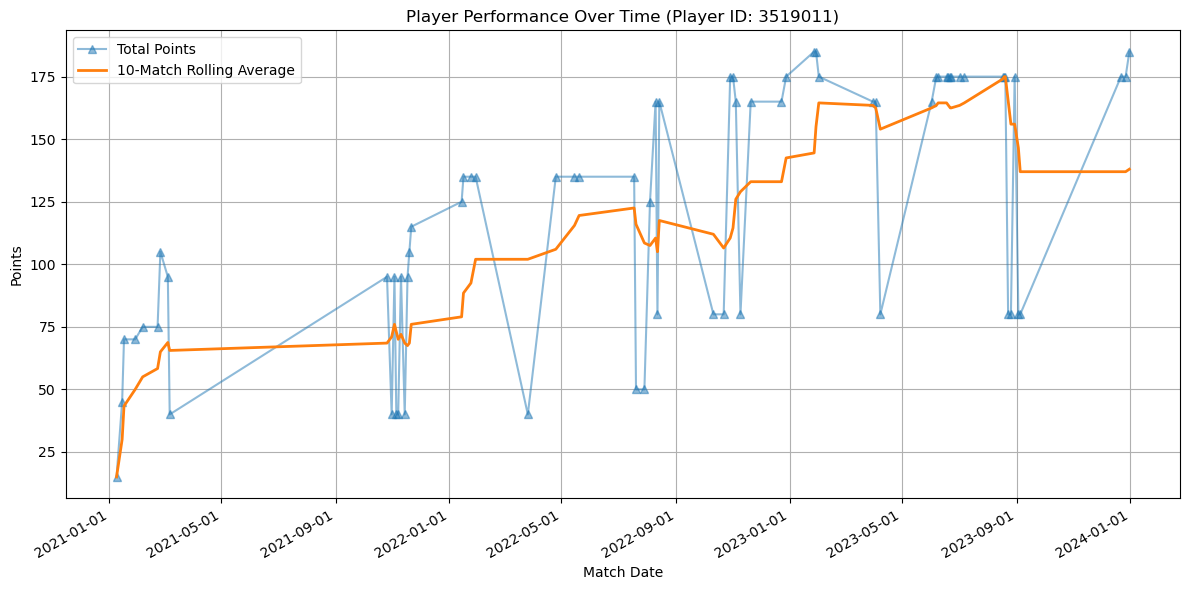

In [37]:
player_perfomance(3519011)

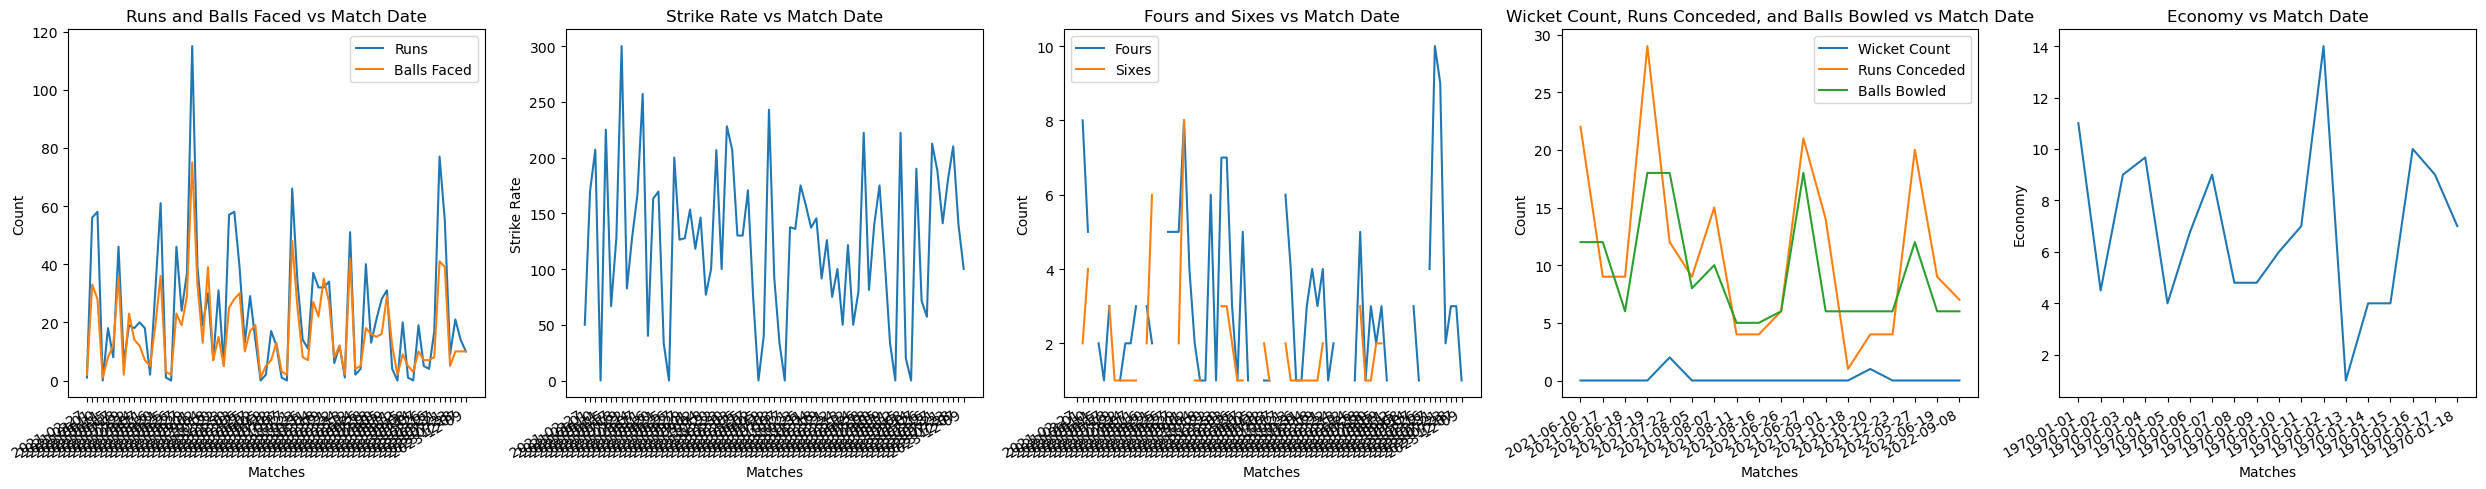

Player ID: 2124002
Batting Performance:
+-------+-------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id     | is_bowler_keeper | is_bowler_captain  |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+-------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------------

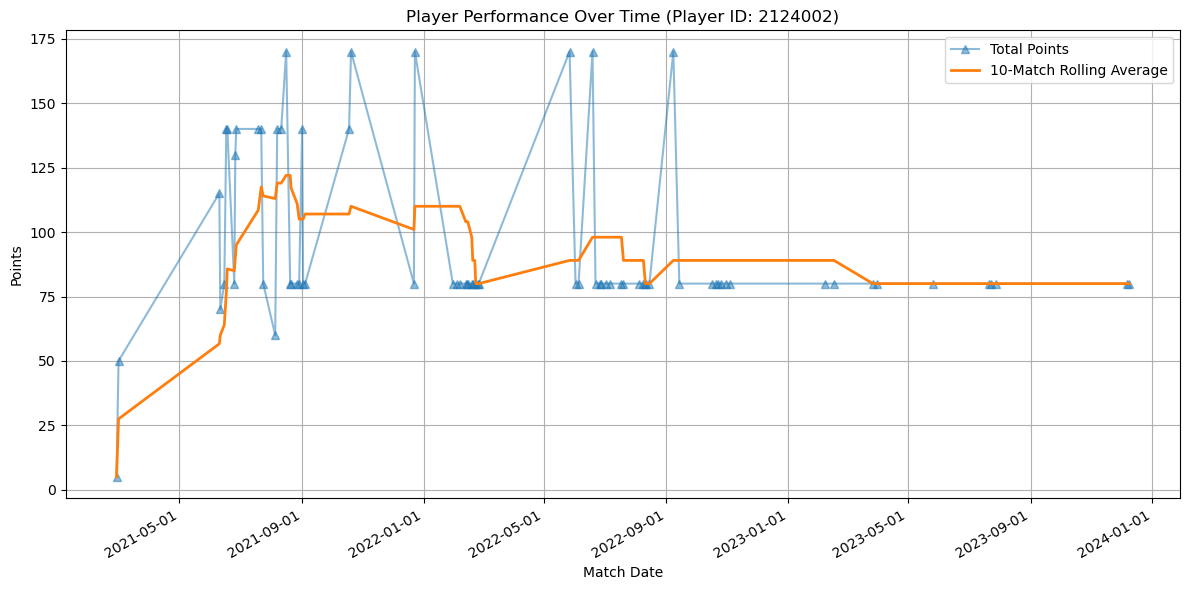

In [38]:
player_perfomance(2124002)

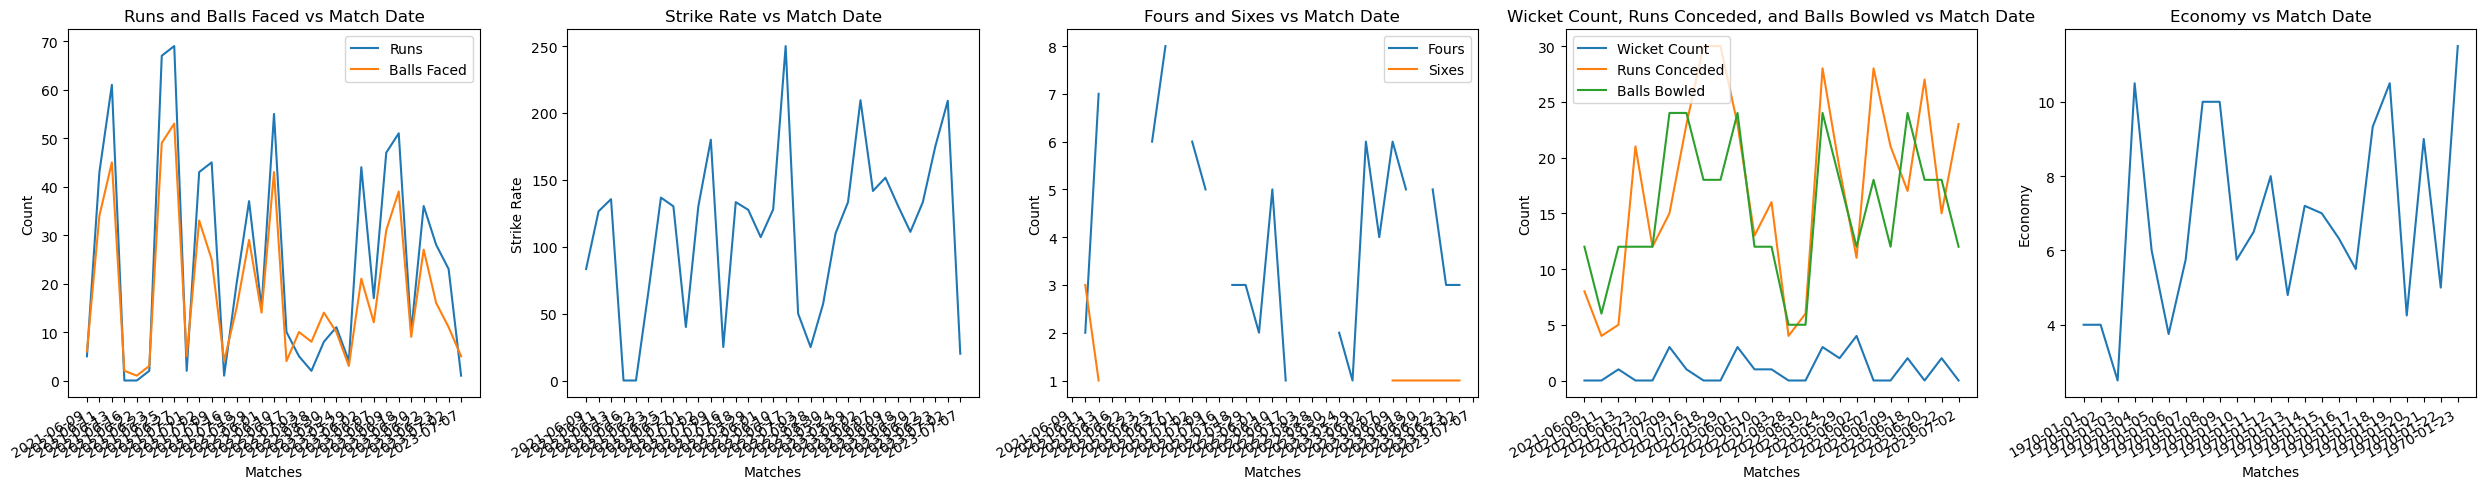

Player ID: 3298427
Batting Performance:
+-------+--------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain  | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id     | is_bowler_keeper |  is_bowler_captain  |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+--------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+--------------------+---------------

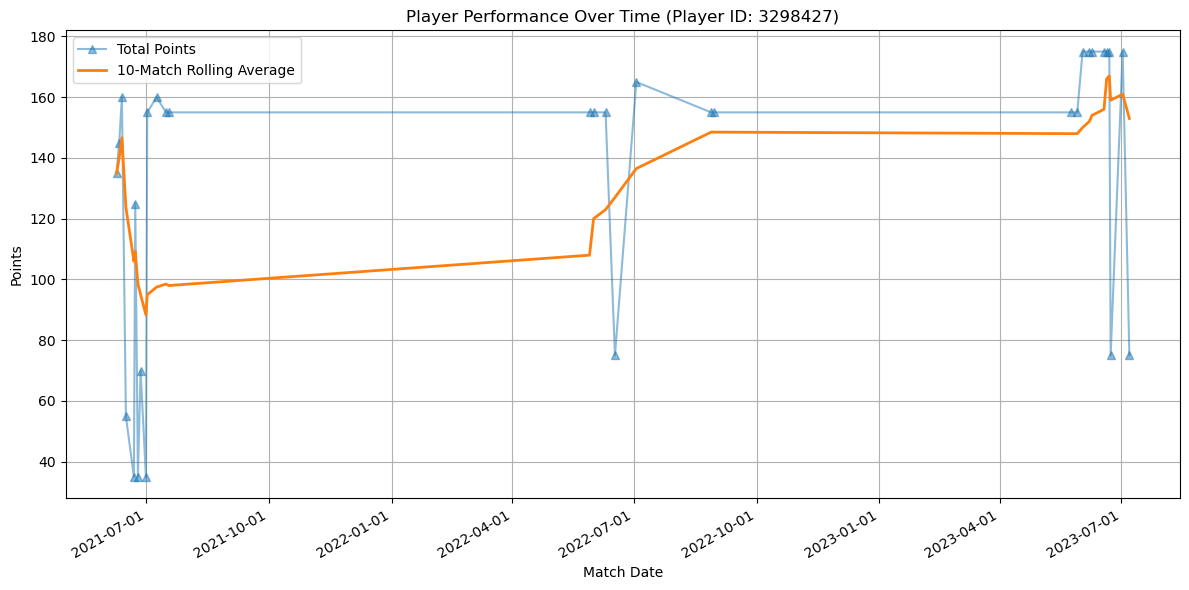

In [39]:
player_perfomance(3298427)

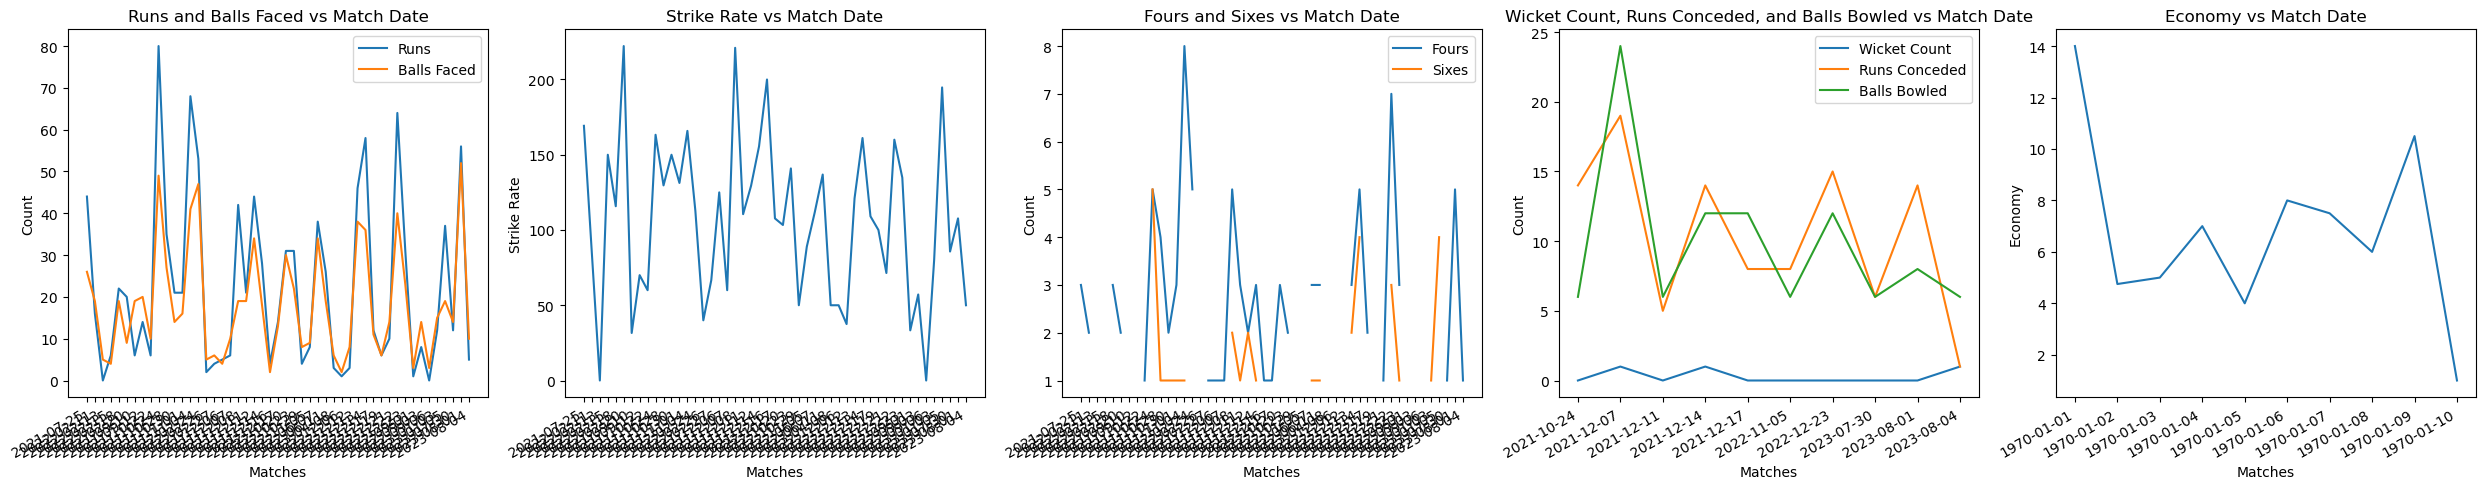

Player ID: 5490582
Batting Performance:
+-------+--------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id      | is_bowler_keeper |  is_bowler_captain   |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+--------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+------------

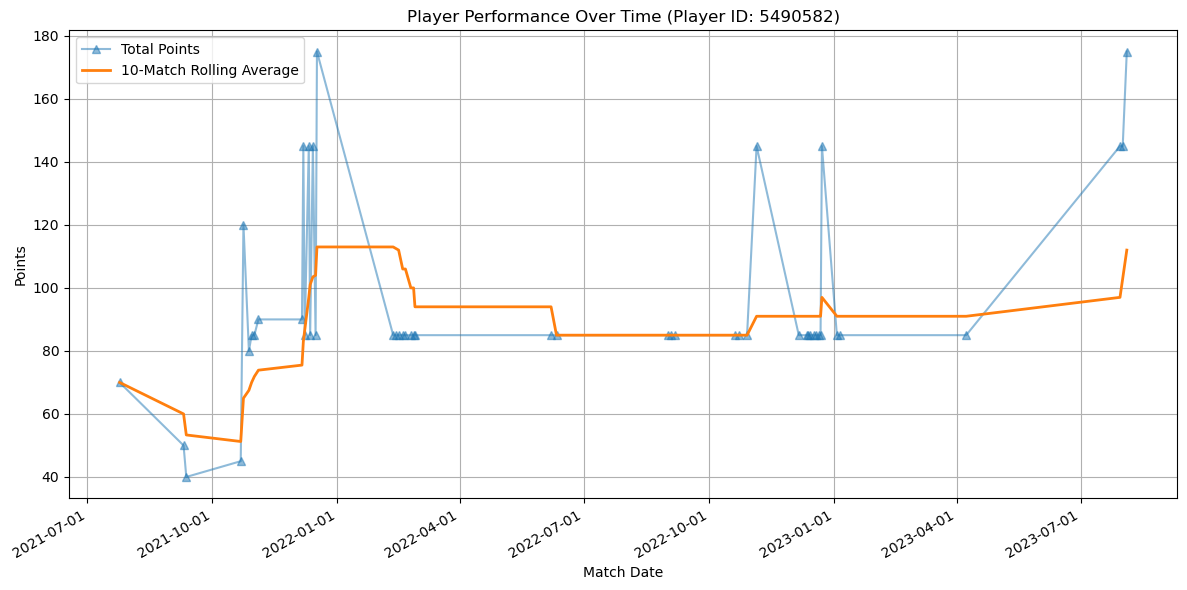

In [40]:
player_perfomance(5490582)

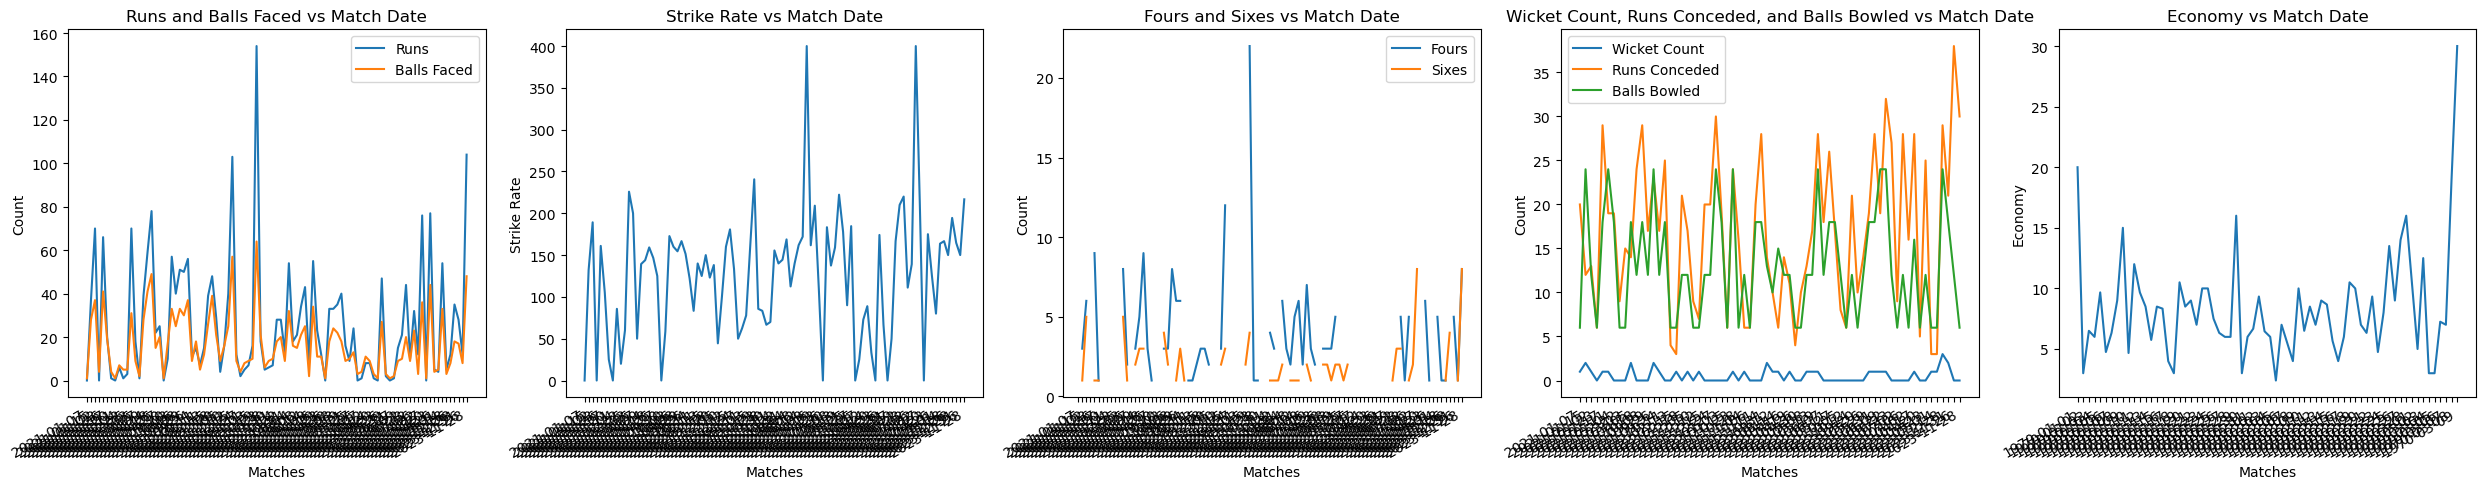

Player ID: 2275195
Batting Performance:
+-------+-------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain  | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id      | is_bowler_keeper | is_bowler_captain |    strike_rate     |       Fours       |       Sixes       |      ingestion_timestamp      |
+-------+-------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------------------+-------------------+---------------------------

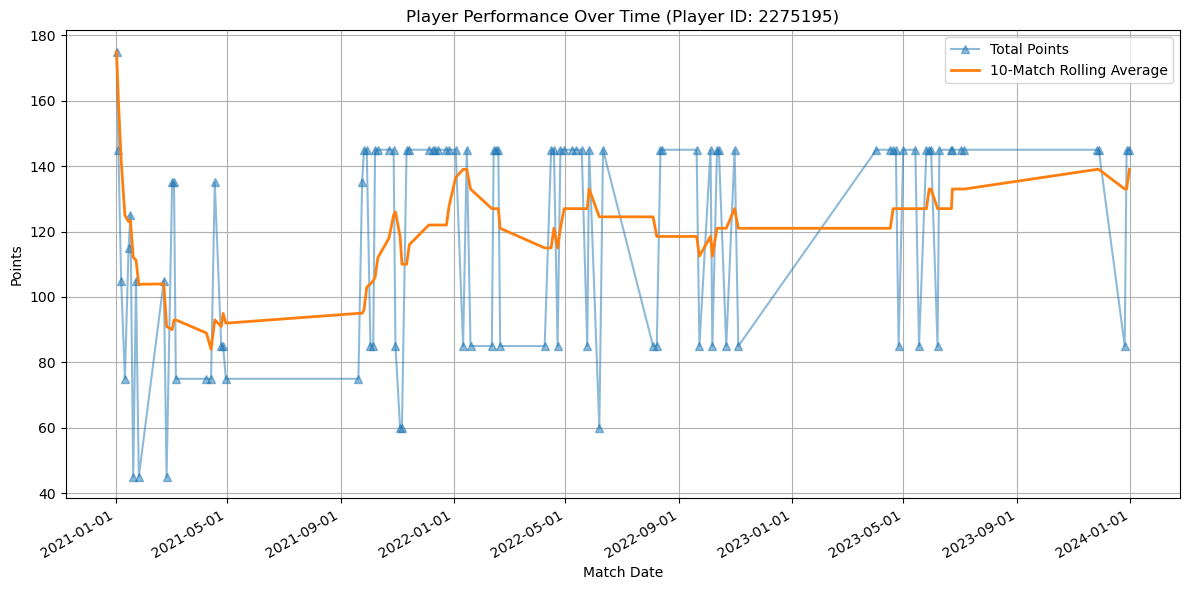

In [41]:
player_perfomance(2275195)

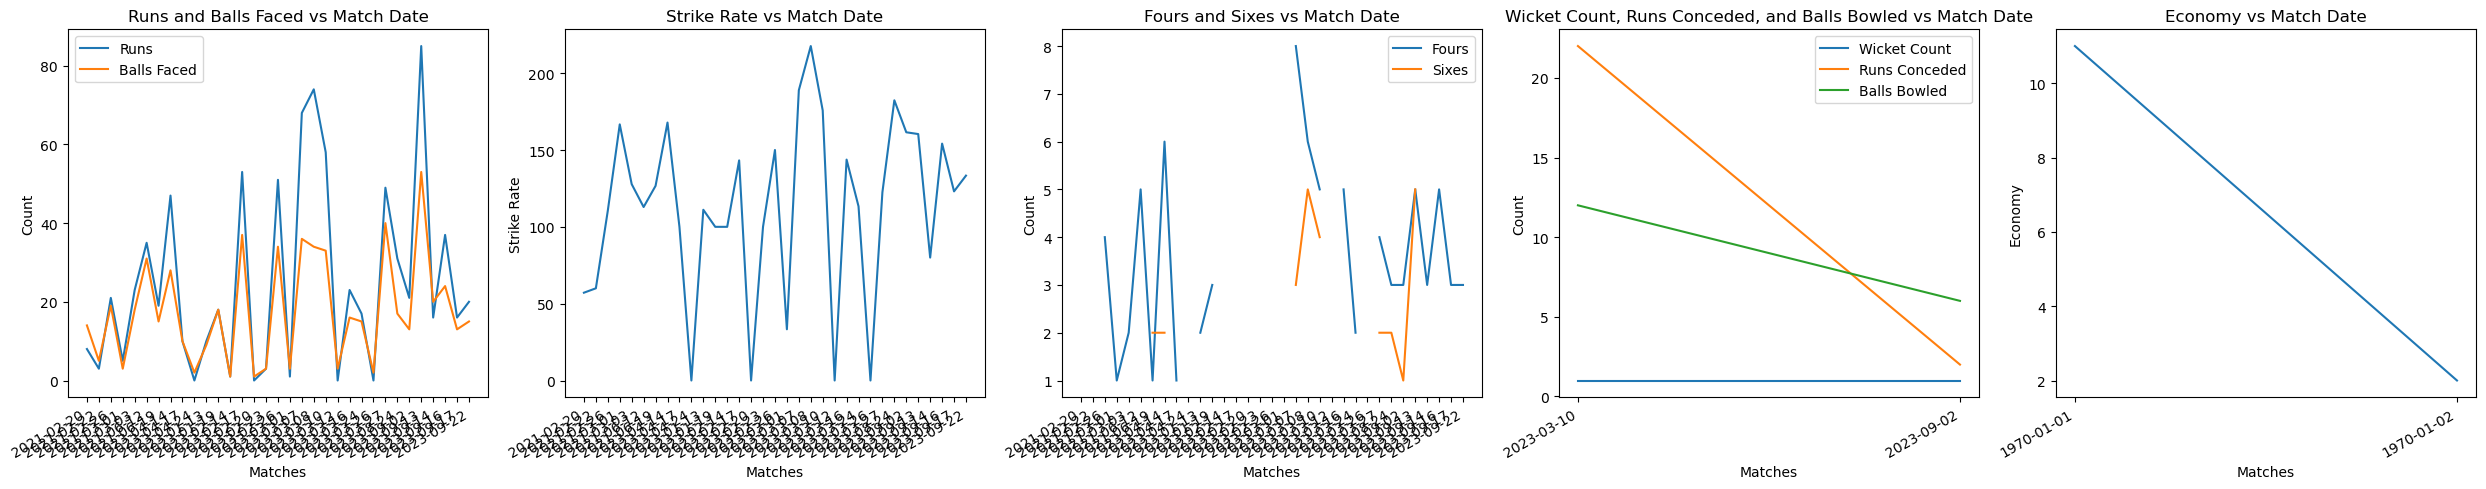

Player ID: 8127230
Batting Performance:
+-------+--------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id     | is_bowler_keeper | is_bowler_captain |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+--------------------+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+--------------------+--------------------+--------------------+------------------------

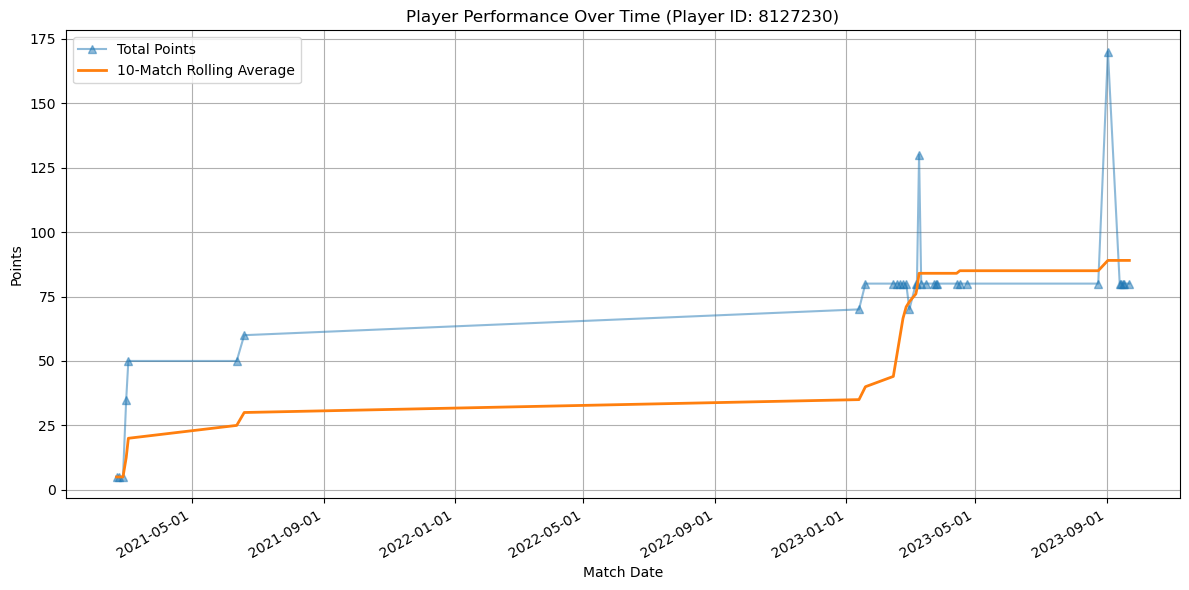

In [42]:
player_perfomance(8127230)

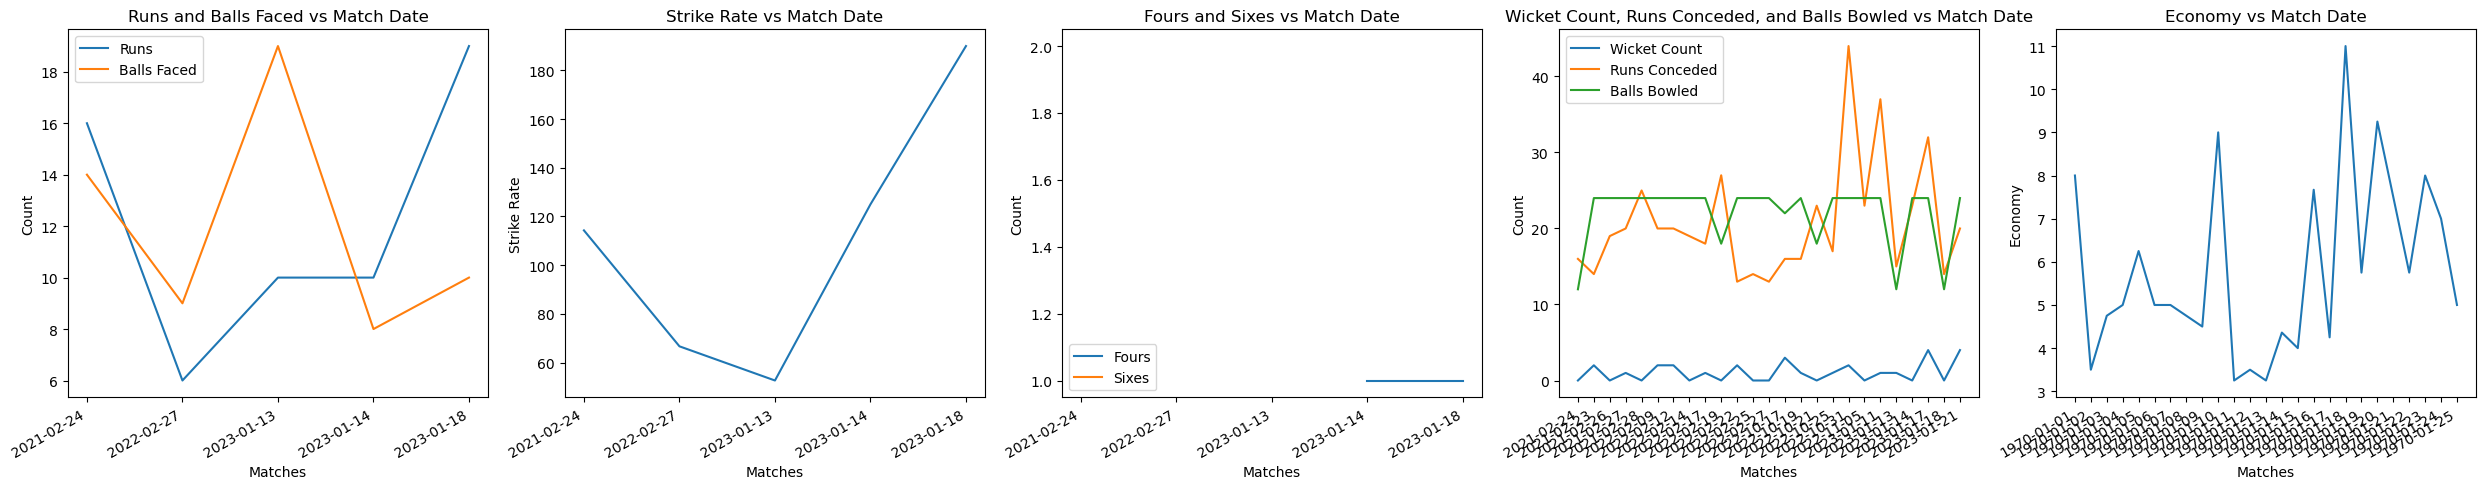

Player ID: 328607
Batting Performance:
+-------+--------------------+------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain | is_batsman_keeper |       inning       |       runs        |    balls_faced    |  over_faced_first  |     bowler_id     | is_bowler_keeper | is_bowler_captain |    strike_rate    |       Fours        | Sixes |      ingestion_timestamp      |
+-------+--------------------+------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------+-------------------------------+
| count |        5.0         |    5.0   

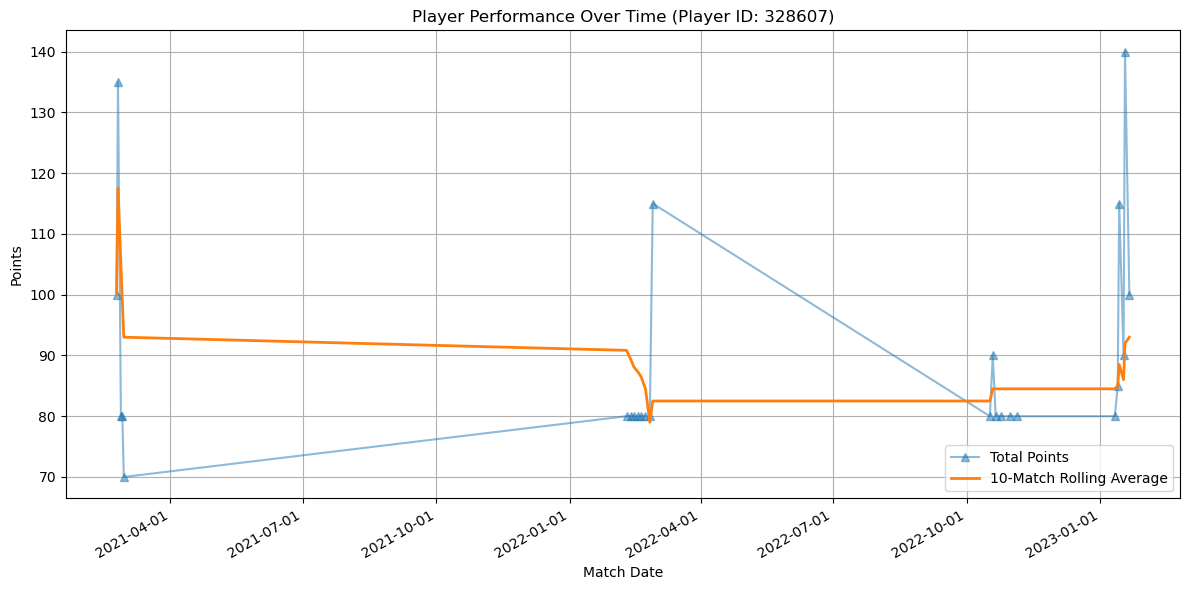

In [43]:
player_perfomance(328607)

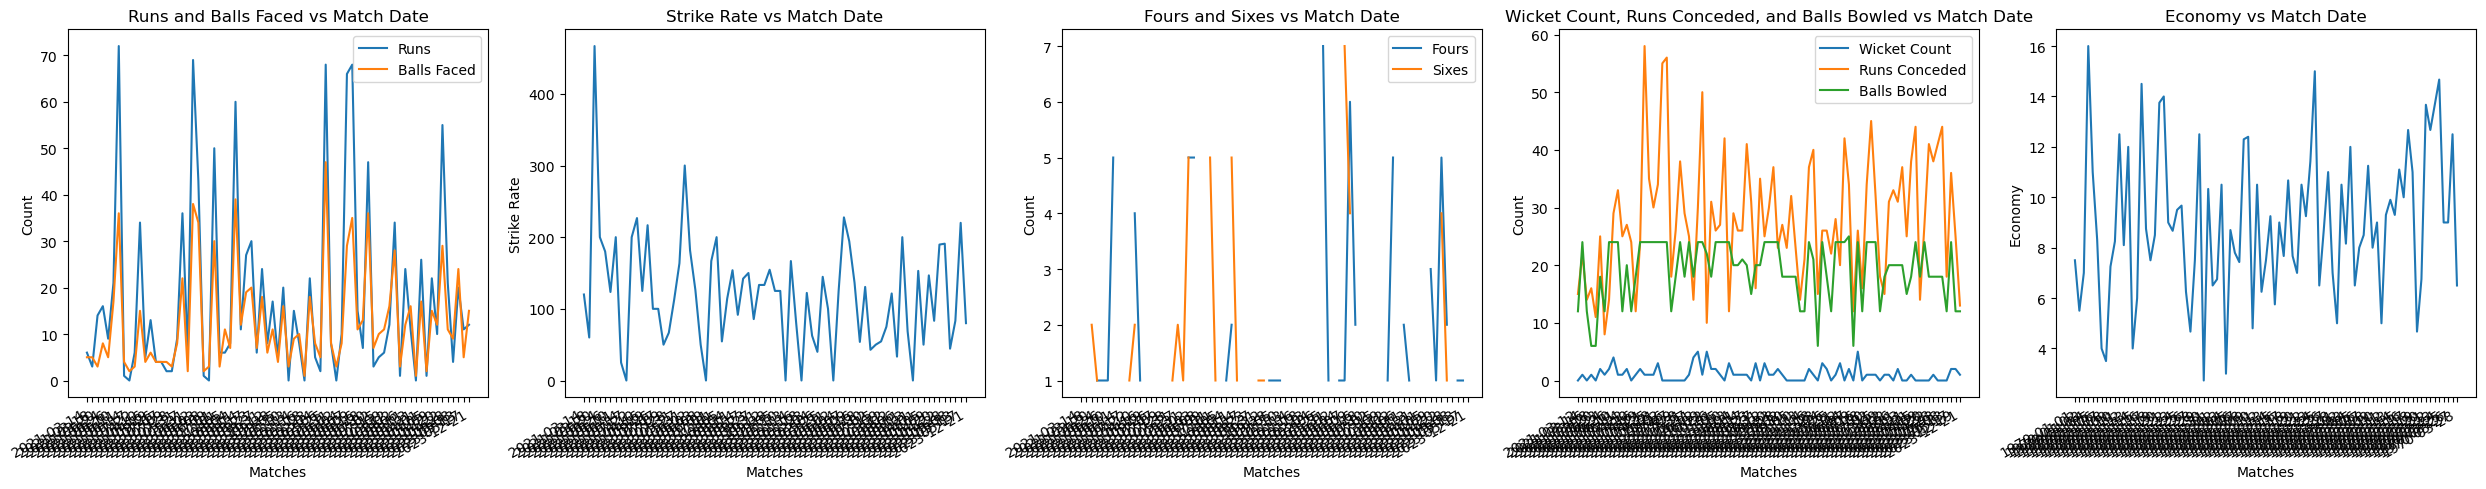

Player ID: 4640824
Batting Performance:
+-------+-------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |     match id      | batsman_id | is_batsman_captain  | is_batsman_keeper |       inning       |        runs        |    balls_faced     |  over_faced_first  |     bowler_id      | is_bowler_keeper | is_bowler_captain  |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+-------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------

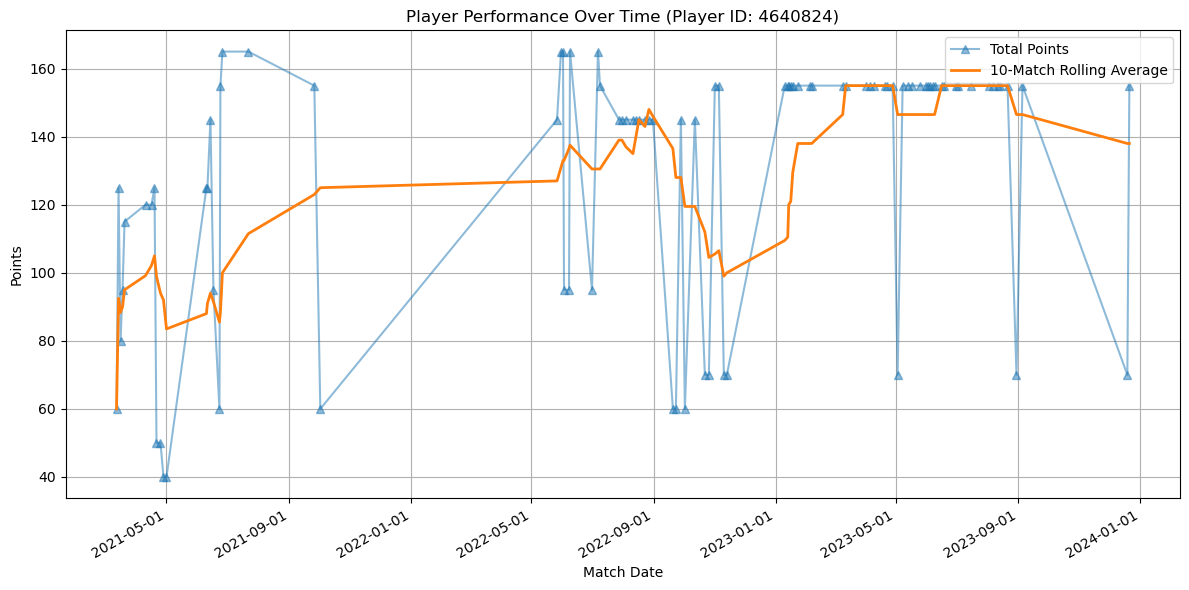

In [44]:
player_perfomance(4640824)

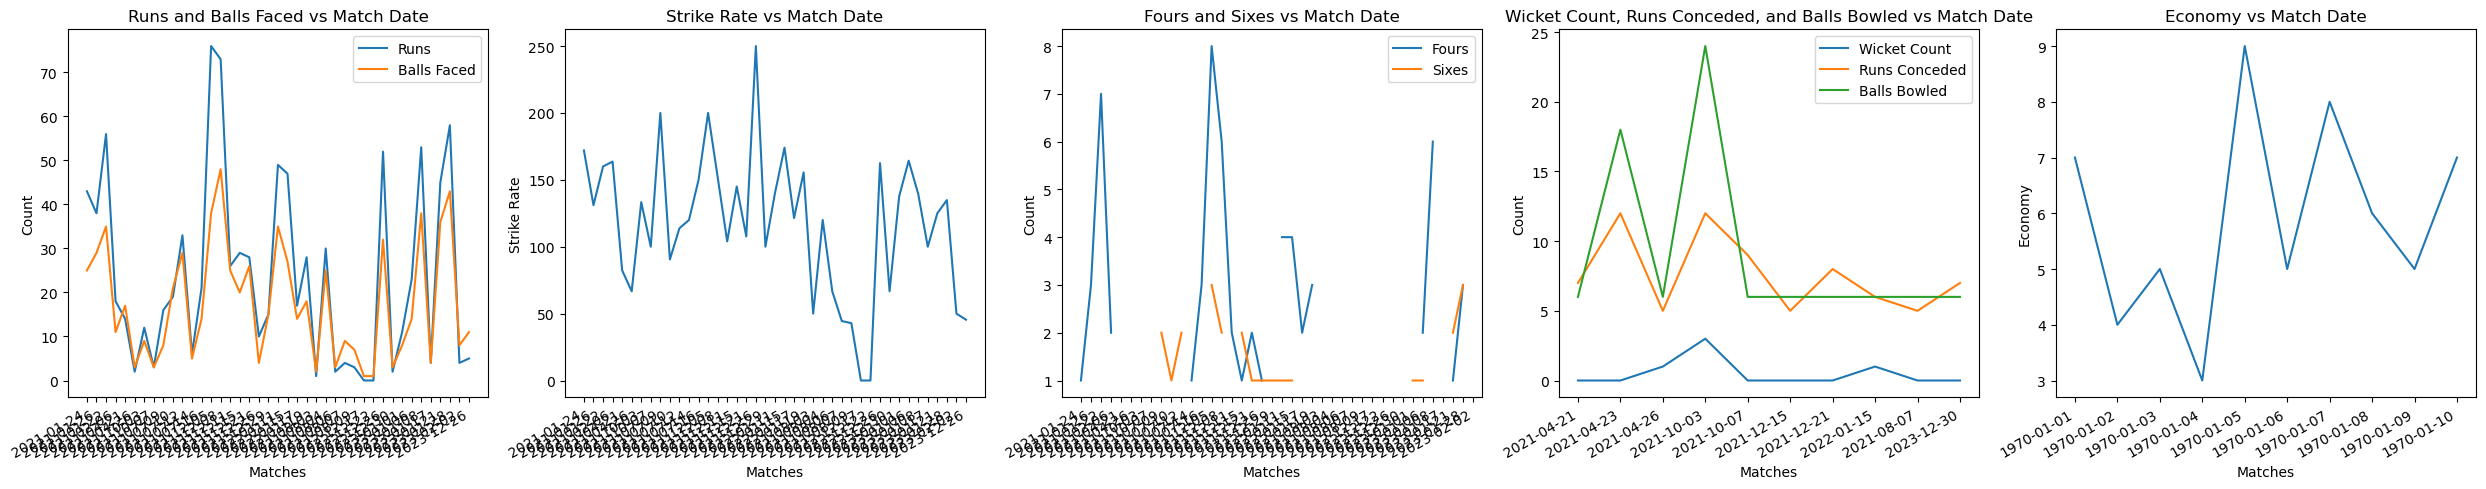

Player ID: 41740
Batting Performance:
+-------+--------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------------+
|       |      match id      | batsman_id | is_batsman_captain  | is_batsman_keeper |       inning       |        runs        |    balls_faced     | over_faced_first  |     bowler_id     | is_bowler_keeper | is_bowler_captain  |    strike_rate     |       Fours        |       Sixes        |      ingestion_timestamp      |
+-------+--------------------+------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------------------

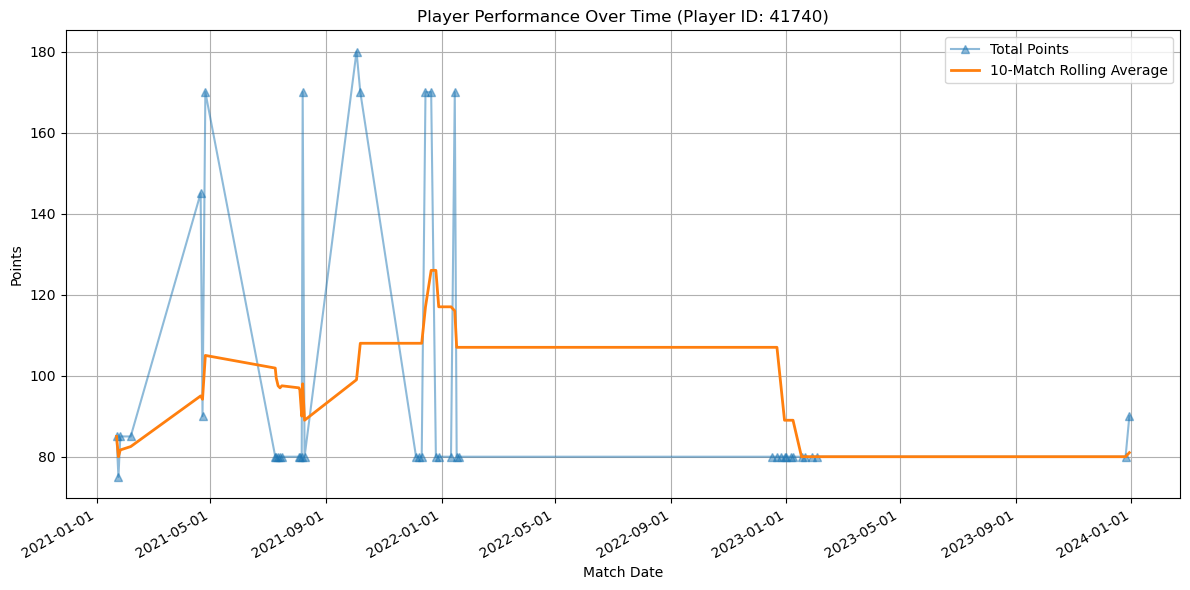

In [45]:
player_perfomance(41740)

**FINAL TEAM**

*Wicketkeeper Candidates*
1. 4888218 - 140 points
2. 2319638 - 140 points

*Batsman Candidates*
1. 2263736 - 100 points
2. 313809 - 100 points
3. 7491224 - 100 points
4. 3125562 - 100 points
5. 2162782 - 100 points

*Bowler Candidates*
1. 5595302 - 110 points
2. 328607 - 110 points 
3. 2943443 - 110 points
4. 3519011 - 100 points (also a all rounder)
5. 5554254 - 100 points
6. 49496 - 100 points
7. 284339 - 100 points
8. 4377694 - 100 points

*All Rounder Candidates*
1. 3298427 - 165 points
2. 3519011 - 165 points (also a bowler)
3. 2124002 - 165 points
4. 4640824 - 155 points
5. 2275195 - 155 points (part of near best 11)
6. 5490582 - 155 points
7. 328607 - 155 points
8. 41740 - 155 points
9. 8127230 - 155 points


The final team is selected on the logic that we select the best 3 batsmen, best 3 bowlers, top 4 all rounders and the best wicketkeeper. \
We have all rounders maximum as they can assist in any role.\
Also, it is often the case that highest ranked bowlers and batsman may not have very high number of overall points - however they are taken for their skills of the particular role.\
Having an extra all rounder also increases our desired score.

Total Team Score : 1,475


In [46]:
team = {
    'batsman': [2263736, 313809, 7491224, 3125562, 2162782], 
    'bowler': [5595302, 328607, 2943443, 3519011, 5554254, 49496, 284339, 4377694], 
    'all-rounder': [3298427, 3519011, 2124002, 4640824, 2275195, 5490582, 328607, 41740, 8127230], 
    'wicketkeeper': [4888218, 2319638]
}

merged = pd.read_excel('merged_player_stats.xlsx')
# Function to filter and print stats
def print_stats(role, player_ids):
    filtered_stats = merged[merged['player_id'].isin(player_ids)]
    print(f"Stats for {role.capitalize()}:")
    print(tabulate(filtered_stats, headers='keys', tablefmt='pretty'))
    print("\n")

# Print stats for each role
for role, player_ids in team.items():
    print_stats(role, player_ids)

Stats for Batsman:
+-----+-----------+--------+---------------------+-------------------+------+------+-------------------+----------------+---------+---------------------+---------+-----------------+----------------+------------------+--------------+----------------+--------------+
|     | player_id |  runs  | batting_strike_rate |  batting_average  | 100s | 50s  | is_batsman_keeper | batting_points | wickets | bowling_strike_rate | economy | bowling_average | 4w_per_innings | is_bowler_keeper | balls_bowled | bowling_points | total_points |
+-----+-----------+--------+---------------------+-------------------+------+------+-------------------+----------------+---------+---------------------+---------+-----------------+----------------+------------------+--------------+----------------+--------------+
| 478 | 3125562.0 | 2551.0 |      136.9785       |      31.8875      | 4.0  | 19.0 |        0.0        |     100.0      |   nan   |         nan         |   nan   |       nan       |     

In [47]:
final_team = {
    'batsman': [2263736, 313809, 7491224], 
    'bowler': [5595302, 328607, 2943443], 
    'all-rounder': [3298427, 3519011, 2124002, 4640824], 
    'wicketkeeper': [4888218]
}

In [48]:
# Columns to select from the merged_stats dataframe
columns_to_select = [
    'player_id', 'total_points', 'runs', 'batting_strike_rate', 'batting_average', '100s', '50s',
    'wickets', 'bowling_strike_rate', 'economy', 'bowling_average', '4w_per_innings'
]

# Create an empty list to hold the rows
rows = []

# Iterate through the final_team dictionary
for role, player_ids in final_team.items():
    for player_id in player_ids:
        # Filter the dataframe for the current player_id
        player_stats = merged_stats[merged_stats['player_id'] == player_id]
        # Select the necessary columns and add the role column
        if not player_stats.empty:
            player_row = player_stats[columns_to_select].iloc[0].tolist()
            player_row.insert(2, role)  # Insert the role after the total_points column
            rows.append(player_row)

# Create a dataframe from the rows list
final_df = pd.DataFrame(rows, columns=[
    'player_id', 'total_points', 'role', 'runs', 'batting_strike_rate', 'batting_average', '100s', '50s',
    'wickets', 'bowling_strike_rate', 'economy', 'bowling_average', '4w_per_innings'
])


# Pretty print the final dataframe
print(tabulate(final_df, headers='keys', tablefmt='pretty'))

print("\n\n The total score of the final team is : ", final_df['total_points'].sum())

# Write the dataframe to the existing CSV file
final_df.to_csv('66715044e93d9_product_round2_submission_template.csv', index=False)


+----+-----------+--------------+--------------+--------+---------------------+-------------------+------+------+---------+---------------------+-------------------+-------------------+----------------+
|    | player_id | total_points |     role     |  runs  | batting_strike_rate |  batting_average  | 100s | 50s  | wickets | bowling_strike_rate |      economy      |  bowling_average  | 4w_per_innings |
+----+-----------+--------------+--------------+--------+---------------------+-------------------+------+------+---------+---------------------+-------------------+-------------------+----------------+
| 0  | 2263736.0 |    100.0     |   batsman    | 4031.0 |  115.6732608695652  | 43.81521739130435 | 2.0  | 38.0 |   nan   |         nan         |        nan        |        nan        |      nan       |
| 1  | 313809.0  |    100.0     |   batsman    | 2798.0 |  114.3880952380952  | 33.30952380952381 | 3.0  | 20.0 |   nan   |         nan         |        nan        |        nan        |   